# Data Analysis Lab 2022: Assignment

Emma Vandrey, 10019590

In [1]:
import os
import pandas as pd
import sys
import subprocess
import uuid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from statistics import mean

In [2]:
exe_dir = 'C:/Users/emmav/OneDrive/Dokumente/DataAnalysisLab22/datalab_ss22/code' # directory where the executable is found /PATH/TO/PROBER
output_dir = 'C:/Users/emmav/OneDrive/Dokumente/DataAnalysisLab22/datalab_ss22/code' # directory to save the data files
data_dir =  'C:/Users/emmav/OneDrive/Dokumente/DataAnalysisLab22/datalab_ss22/code'  # directory for jupyter to find the data in - same as data_dir if not using 

In this notebook, the goal is to detect unknown signals in noisy data. The signals are expected to be in the range of f $\in$ \[10,1000\]Hz, $\phi \in$ \[0,2$\pi$\] and A $\in$ \[0.5,2\]. All data sets have the following properties:

In [3]:
T_obs = 180.0;
dt_data = 1/4096;
N_data = int(180/dt_data);
sigma_data = 25.0;

##  Finding a suitable setup

To find a suitable setup, multiple data sets with random frequency and phase (within a certain range) are generated and searched for around a small box of templates. First, the functions used to generate the signals, search for them and calculate the mismatch between the result on-target and at a point of the template bank are defined. Also, a few other functions used to plot data, import and work with results of prober and work with large amounts of files are defined.

In [4]:
# Call generate source with given parameters, use default values if no input
def generate_source(
    outputFile=None, 
    sigma=25.0, 
    delta_T=dt_data, 
    N=N_data,
    f=0, 
    phi=0, 
    A=0, 
    r=0
):
    """
    Usage: ./generate_source  [-h] [-o <file>] [-s <float>] [-d <float>] [-N <int>] [-f <float>] [-p <float>] [-a <float>] [-r <int>]
      -o, --output=<file>       output file
      -s, --sigma=<float>       standard deviation sigma
      -d, --deltaT=<float>      delta T betwean measurements
      -N, --length=<int>        number of elements
      -f, --freq=<float>        frequency
      -p, --phase=<float>       phase
      -a, --amplitude=<float>   signal amplitude
      -r, --random=<int>        if set to 1, generate random signal
      -h, --help                print this help and exit
    """
    if delta_T == None : 
        delta_T = 1/N
    if outputFile == None:
        outputFile = "data_" + str(uuid.uuid4()) + ".csv"
    
    outputPath = os.path.join(output_dir, outputFile) # output_dir + "/" + "myfilename.csv"
    exe_path = os.path.join(exe_dir, 'generate_source')
    
    cmd_str = f"{exe_path} -o {outputPath} -s {sigma} -d {delta_T} -N {N} -f {f} -p {phi} -a {A} -r {r}"
    
    # Optionally print the command line and test it outside the notebook
    #print(cmd_str)
    
    cmd = cmd_str.split(' ')
    process = subprocess.Popen(cmd,stdout=subprocess.PIPE)

    out, err = process.communicate()
    if err:
        print('The process raised an error:', err.decode())
    #if out:
        #print('The process has an output:', out.decode())

    return os.path.join(data_dir, outputFile)


In [5]:
# input: list of frequencies, list of phases
# output: list of file paths of the generated sources
# generates one data set per frequency and per phase value
# number of generated data sets: length of freq. list * length of phase list
def generate_sources_from_list(freq_list, phase_list, amplitude):
    file_paths = []

    for i in range(len(freq_list)):
        for j in range(len(phase_list)):
            freq = freq_list[i]
            phase = phase_list[j]
            filename = f"data_f{str(freq).replace('.', '_')}_p{str(phase).replace('.', '_')}_a{str(amplitude).replace('.', '_')}_{str(i)}.txt"
        
            generate_source(
                outputFile=filename, 
                sigma=25.0, 
                delta_T=dt_data, 
                N=N_data,
                f=freq, 
                phi=phase, 
                A=amplitude, 
                r=0
            )
            file_paths.append(f"{output_dir}/{filename}")
    
    return file_paths

In [9]:
def prober(inputFile, outputFile=None, f=0, phi=0, templateFile=None, mod=1):
    """
    Usage: ./prober  [-h] [-i <file>] [-o <file>] [-f <float>] [-p <float>] [-t <file>] [-m <int>]
      -i, --input=<file>        input file
      -o, --output=<file>       output file
      -f, --freq=<float>        frequency
      -p, --phase=<float>       phase
      -h, --help                print this help and exit
      -t, --templatebank=<file> template bank file
      -m, --method=<int>        select method to analyze signal 1, 2 or 3
    """
    
    if outputFile == None:
        outputFile = "results_" + str(uuid.uuid4()) + ".csv"
    
    exe_path = os.path.join(exe_dir, 'prober')
    
    """
    prober -i data/data_01.csv -o data/results_01.csv -t template.txt -m 1
    """
    
    cmd_str = f"{exe_path} -i {os.path.join(output_dir, inputFile)} -o {os.path.join(output_dir, outputFile)} -m {mod}"
    
    if templateFile:
        cmd_str += f" -t {os.path.join(output_dir, templateFile)} "
    else:
        cmd_str += f" -f {f} -p {phi}"
    
    # Optionally print the command line and test it outside the notebook
    #print(cmd_str)
    
    cmd = cmd_str.split(' ')
    process = subprocess.Popen(cmd,stdout=subprocess.PIPE)
    out, err = process.communicate()
    if err:
        print('The process raised an error:', err.decode())
    if out:
        print(out.decode()) #'The process has an output:', 
    if os.path.isfile(outputFile):
        print(f"Output generated in file {outputFile}")

    return f"{output_dir}/{outputFile}"
    

In [11]:
# analyses the files in file_list with the given method, using a template bank
# input: list of file paths, method, name of output files
# output: list of file paths of result files
def prober_for_list_template_bank(file_list, template_bank, method = 1, output_file_name = "output"):
     
    file_paths = []
    
    for i in range(len(file_list)):
        
        prober(inputFile = file_list[i], outputFile=f"{output_file_name}_{str(i)}.txt",templateFile=template_bank, mod=method)
        file_paths.append(f"{output_dir}/{output_file_name}_{str(i)}.txt")
    
    return file_paths

In [10]:
# Uses method 1 or 2 (depending on input) to analyse input file, returns frequency, phase and s-value in list of floats
def prober_m12(inputFile, outputFile=None, f=0, phi=0, templateFile=None, mod=1):
    """
    Usage: ./prober  [-h] [-i <file>] [-o <file>] [-f <float>] [-p <float>] [-t <file>] [-m <int>]
      -i, --input=<file>        input file
      -o, --output=<file>       output file
      -f, --freq=<float>        frequency
      -p, --phase=<float>       phase
      -h, --help                print this help and exit
      -t, --templatebank=<file> template bank file
      -m, --method=<int>        select method to analyze signal 1, 2 or 3
    """
    
    if mod == 3:
        print("This is the wrong function.")
        return 
    
    exe_path = os.path.join(exe_dir, 'prober')
    
    """
    prober -i data/data_01.csv -o data/results_01.csv -t template.txt -m 1
    """
    
    cmd_str = f"{exe_path} -i {os.path.join(output_dir, inputFile)} -m {mod}"
    
    if templateFile:
        cmd_str += f" -t {output_dir}/{templateFile} "
    else:
        cmd_str += f" -f {f} -p {phi}"
    
    # Optionally print the command line and test it outside the notebook
    #print(cmd_str)
    
    cmd = cmd_str.split(' ')
    process = subprocess.Popen(cmd,stdout=subprocess.PIPE)
    out, err = process.communicate()
    if err:
        print('The process raised an error:', err.decode())
        return 
    #print(out.decode()) 
    out_string = str(out.decode())
    return_list = []

    for item in out_string.split():
            return_list.append(float(item))
        
    return return_list
        

In [553]:
# plots the results of prober, used with a template bank with N_df frequency steps and N_ph phase steps, as a contour plot
# the plot axes correspond to the frequency and phase
# the plot is saved as a .png file
def phase_freq_plot(result_file, freq=None, phase=None, N_df=100, f_min=10, f_max=1000, mod=1, N_ph=6, dx_axis_ticks = None, fig_file_name = None):
    
    results = np.loadtxt(result_file)
    
    plt.figure(figsize = (15,4))
    levels = np.linspace(np.min(results[:,2]),np.max(results[:,2]),30)
    CS = plt.contourf(results[:,0].reshape(N_df + 1,N_ph + 1),results[:,1].reshape(N_df + 1,N_ph + 1),results[:,2].reshape(N_df + 1,N_ph + 1),levels)
    
    # Plot best match
    if mod == 1 :
        # For S_1 get the maximum
        plt.scatter(results[np.argmax(results[:,2])][0], results[np.argmax(results[:,2])][1], marker="o", c='violet', 
                    label="Loudest point")
        best_phi, best_f, best_val = results[np.argmax(results[:,2])]
    elif mod == 2: 
        # For S_2 get the minimum
        plt.scatter(results[np.argmin(results[:,2])][0], results[np.argmin(results[:,2])][1], marker="o", c='violet', 
                    label="Loudest point")
        best_phi, best_f, best_val = results[np.argmin(results[:,2])]
        
    if (freq and phase):
        plt.scatter(freq,phase,marker="x", label="Injection point", c='red')
        
    
    #plt.title(f"Searching over frequency and phase - 2D search $S_{mod}$")
    plt.legend(loc='best')
    plt.grid()
    plt.xlabel("Frequency [Hz]", fontname="Arial", fontsize=13)
    plt.ylabel("Phase", fontname="Arial", fontsize=13)
    plt.xlim(f_min, f_max)
    plt.colorbar(CS, label=f"Prober output $S_{mod}$")
    plt.grid(color = 'black')
    # save the plot as a .png
    if fig_file_name == None:
        plt.savefig(f"2d_plot_f{str(freq).replace('.', '_')}_p{str(phase).replace('.', '_')}_Ndf{str(N_df)}_mod{mod}.png", dpi=800)
    else:
        plt.savefig(f"2d_plot_{fig_file_name}_Ndf{str(N_df)}_mod{mod}.png", dpi=800)
    plt.show()
    plt.close()
    
    return #[y_tick_list, y_labels]

In [16]:
# imports the data in file (should be result of method 3 of prober)
# plots the Fourier spectrum in the given frequency range
def import_plot_data_m3(file1, file2 = None, fmin = 10, fmax = 1000, plot_title = None):
    input_data = np.loadtxt(file1)
    X = input_data[:,0]
    Y = input_data[:,2]
    
    plt.figure(figsize = (12,4))
    plt.plot(X,Y)
   
    plt.xlim(fmin, fmax)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("S")
    
    if plot_title:
        plt.title(plot_title)
    plt.show()
    
    return

In [53]:
# return the best result of prober used with a template bank and the corresponding frequency and phase
# output: [frequency, phase, best s-value]
def get_best_result(prober_result_file, method = 1):
    
    result_data = np.loadtxt(prober_result_file)
    if method == 1:
        best_index = np.argmax(result_data[:,2])
    elif method == 2:
        best_index = np.argmin(result_data[:,2])
    else:
        print("This is not a suitable method, use method 1 or 2.")
        return
    
    
    return result_data[best_index]

In [12]:
# returns the frequency occuring in a file name of format "data_f[frequency seperated by _ instead of .]_p[phase, also separated by _].txt"
def get_frequency(input_string):
    start = input_string.find('f') + 1
    freq_string = ""
    count = 0
    
    for i in range(start, len(input_string)):
        char_i = input_string[i]
        if '0' <= char_i and char_i <='9': 
            freq_string = freq_string + char_i
        elif char_i == '_' and count == 0:
            freq_string = freq_string + '.'
            count+=1
        elif char_i == '_' and count == 1:
            break
        else: 
            break
            
    freq = float(freq_string)
    
    return freq

In [13]:
# returns the phase occuring in a file name of format "data_f[frequency seperated by _ instead of .]_p[phase, also separated by _].txt"
def get_phase(input_string):
    start = input_string.find('p') + 1
    phase_string = ""
    count = 0
    
    for i in range(start, len(input_string)):
        char_i = input_string[i]
        if '0' <= char_i and char_i <='9': 
            phase_string = phase_string + char_i
        elif char_i == '_' and count == 0:
            phase_string = phase_string + '.'
            count+=1
        elif char_i == '_' and count == 1:
            break
        else: 
            break
            
    phase = float(phase_string)
    
    return phase

### Generating the sources and template banks

To examine how the mismatch changes for template banks with varying accuracy, signals of random (but known) frequency and phase are generated and analysed using method 1 and 2 of prober. These random signals lie in one of three arbitrarily chosen intervals in order to keep the computation time within a reasonable duration. The intervals are:
1. $f \in [11.0, 11.1], \phi \in [1.0, 2.0]$
2. $f \in [471.0, 471.1], \phi \in [5.0, 6.0]$
3. $f \in [996.0, 996.1], \phi \in [3.0, 4.0]$

In [62]:
freq_list_1 = list(np.around(np.array(np.random.uniform(11.0, 11.1, size=(1, 10)).flatten()),3));
phase_list_1 = list(np.around(np.array(np.random.uniform(1.0, 2.0, size=(1, 5)).flatten()),3));
freq_list_2 = list(np.around(np.array(np.random.uniform(471.0, 471.1, size=(1, 10)).flatten()),3));
phase_list_2 = list(np.around(np.array(np.random.uniform(5.0, 6.0, size=(1, 5)).flatten()),3));
freq_list_3 = list(np.around(np.array(np.random.uniform(996.0, 996.1, size=(1, 10)).flatten()),3));
phase_list_3 = list(np.around(np.array(np.random.uniform(3.0, 4.0, size=(1, 5)).flatten()),3));

In [63]:
signals_1 = generate_sources_from_list(freq_list_1, phase_list_1, 2.0);
signals_2 = generate_sources_from_list(freq_list_2, phase_list_2, 2.0);
signals_3 = generate_sources_from_list(freq_list_3, phase_list_3, 2.0);

In [6]:
# generate a template bank with frequencies between fmin and fmax and phases between p_min and p_max
def generate_template_bank(f_min, f_max, f_steps, p_min, p_max, phase_steps, filename):
    
    # generate lists of the frequencies and phases of the templates
    freqs = np.linspace(f_min, f_max, f_steps+1) 
    if p_min != p_max:
        phases = np.linspace(p_min, p_max, phase_steps+1)
    else:
        phases = [p_min]
        
    
    result = []

    for f in freqs:
        for ph in phases:
            result.append([f,ph])
     
    # save the list of templatest in a .txt file, separated by ' '
    np.savetxt(os.path.join(output_dir, filename), result, delimiter=' ')
    file_path = f"{output_dir}/{filename}"
    
    return file_path
    

To get a first idea of what the results of an analysis of the datasets with prober look like, a coarse template bank spanning the whole search space ($f \in [10, 1000], \phi \in [0, 2\pi]$) is generated and one file of each interval is analysed using this template bank and method 1 or 2 of prober. Here, the templates are chosen to have a distance in frequency of $\Delta f = 1\,\textrm{Hz}$ and in phase of $\Delta \phi = 2\pi/3$.

In [170]:
coarse_template_bank = generate_template_bank(10.0, 1000.0, 990, 0, 2*np.pi, 3, f"coarse_template_bank.txt")

In [171]:
result_f11_coarse_tb_m1 = prober(signals_1[22], outputFile="result_signals_1_22_coarse_tb_m1.txt", templateFile=coarse_template_bank, mod=1)
result_f471_coarse_tb_m1 = prober(signals_2[22], outputFile="result_signals_2_22_coarse_tb_m1.txt", templateFile=coarse_template_bank, mod=1)
result_f996_coarse_tb_m1 = prober(signals_3[22], outputFile="result_signals_3_22_coarse_tb_m1.txt", templateFile=coarse_template_bank, mod=1)
result_f11_coarse_tb_m2 = prober(signals_1[22], outputFile="result_signals_1_22_coarse_tb_m2.txt", templateFile=coarse_template_bank, mod=2)
result_f471_coarse_tb_m2 = prober(signals_2[22], outputFile="result_signals_2_22_coarse_tb_m2.txt", templateFile=coarse_template_bank, mod=2)
result_f996_coarse_tb_m2 = prober(signals_3[22], outputFile="result_signals_3_22_coarse_tb_m2.txt", templateFile=coarse_template_bank, mod=2)

The results are plotted as frequency-phase contour plots, the injection point and the loudest point is marked:

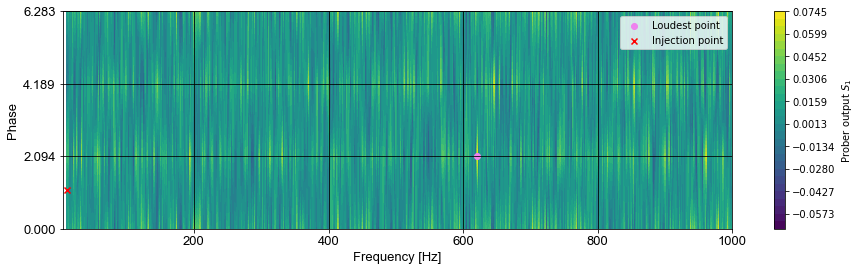

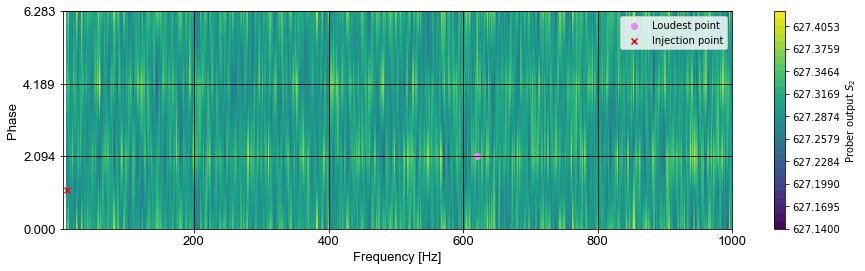

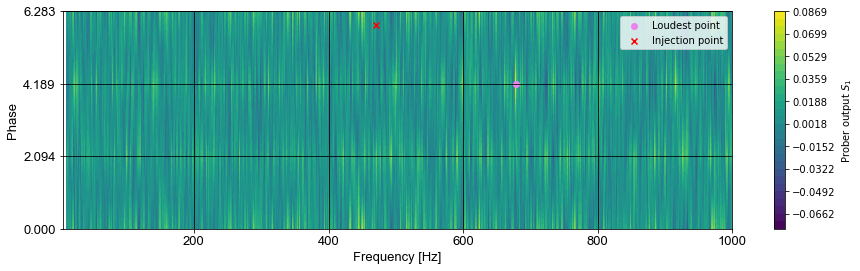

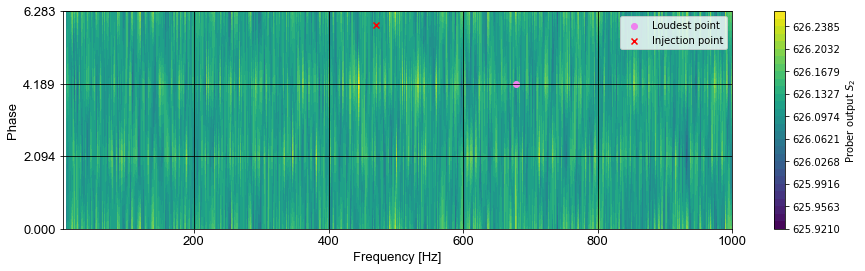

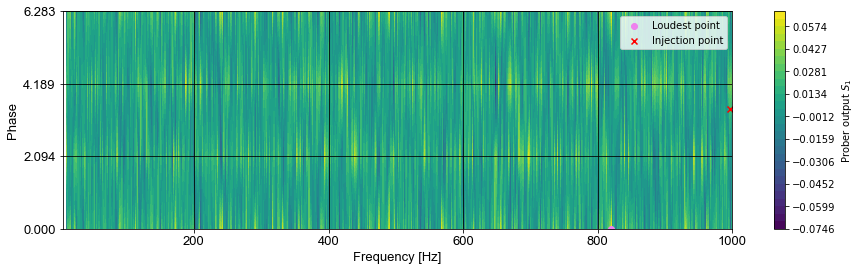

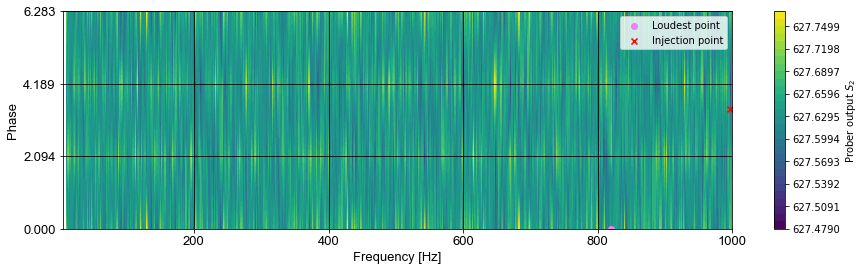

In [432]:
phase_freq_plot(result_f11_coarse_tb_m1, freq=11.04, phase=1.121, N_df=990, f_min=5, f_max=1000, mod=1, N_ph=3)
phase_freq_plot(result_f11_coarse_tb_m2, freq=11.04, phase=1.121, N_df=990, f_min=5, f_max=1000, mod=2, N_ph=3)
phase_freq_plot(result_f471_coarse_tb_m1, freq=471.031, phase=5.883, N_df=990, f_min=5, f_max=1000, mod=1, N_ph=3)
phase_freq_plot(result_f471_coarse_tb_m2, freq=471.031, phase=5.883, N_df=990, f_min=5, f_max=1000, mod=2, N_ph=3)
phase_freq_plot(result_f996_coarse_tb_m1, freq=996.068, phase=3.464, N_df=990, f_min=5, f_max=1000, mod=1, N_ph=3)
phase_freq_plot(result_f996_coarse_tb_m2, freq=996.068, phase=3.464, N_df=990, f_min=5, f_max=1000, mod=2, N_ph=3)

As the plots above show, the results obtained by using the coarse template bank with $\Delta f = 1\,\textrm{Hz}$ differ significantly from the actual injected parameters, i.e. one could miss a lot of signals. Therefore, a template bank with medium accuracy ($\Delta f = 0.1\,\textrm{Hz}$) is tested in the same way as before.

In [220]:
medium_template_bank = generate_template_bank(10.0, 1000.0, 9900, 0, 2*np.pi, 3, f"medium_template_bank.txt")

In [222]:
result_f11_medium_tb_m1 = prober(signals_1[22], outputFile="result_signals_1_22_medium_tb_m1.txt", templateFile=medium_template_bank, mod=1)
result_f471_medium_tb_m1 = prober(signals_2[22], outputFile="result_signals_2_22_medium_tb_m1.txt", templateFile=medium_template_bank, mod=1)
result_f996_medium_tb_m1 = prober(signals_3[22], outputFile="result_signals_3_22_medium_tb_m1.txt", templateFile=medium_template_bank, mod=1)
result_f11_medium_tb_m2 = prober(signals_1[22], outputFile="result_signals_1_22_medium_tb_m2.txt", templateFile=medium_template_bank, mod=2)
result_f471_medium_tb_m2 = prober(signals_2[22], outputFile="result_signals_2_22_medium_tb_m2.txt", templateFile=medium_template_bank, mod=2)
result_f996_medium_tb_m2 = prober(signals_3[22], outputFile="result_signals_3_22_medium_tb_m2.txt", templateFile=medium_template_bank, mod=2)

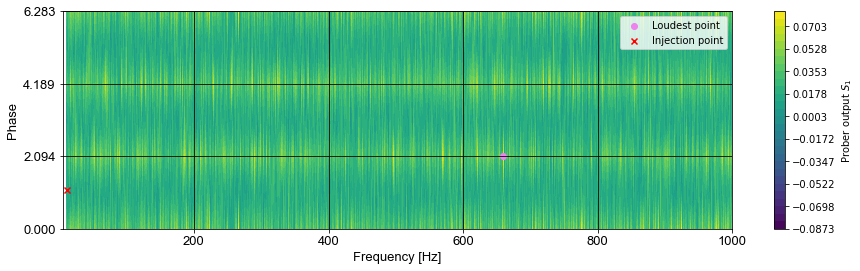

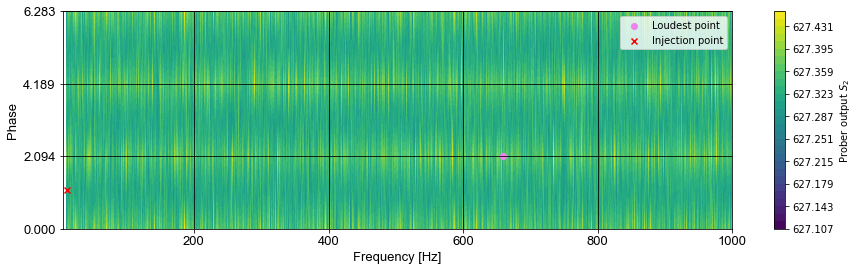

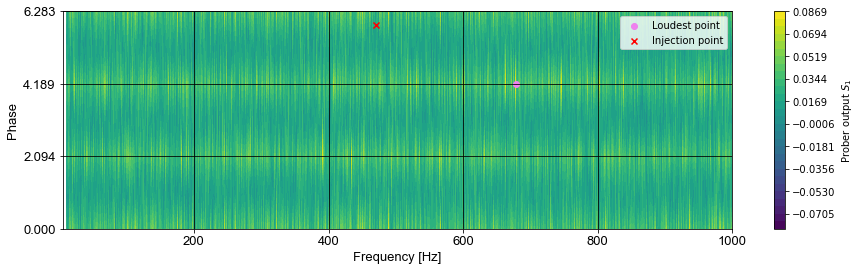

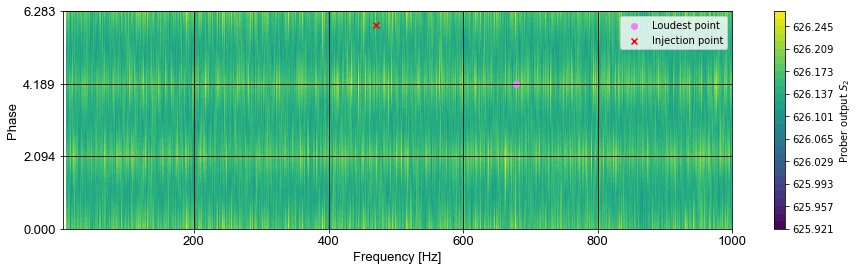

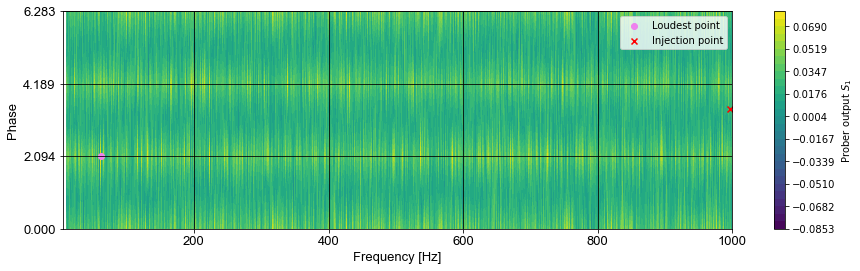

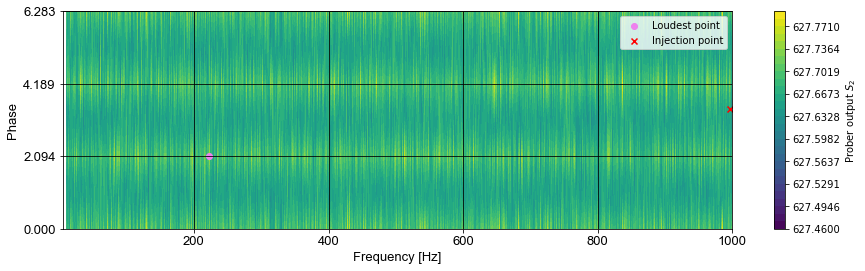

In [433]:
phase_freq_plot(result_f11_medium_tb_m1, freq=11.04, phase=1.121, N_df=9900, f_min=5, f_max=1000, mod=1, N_ph=3)
phase_freq_plot(result_f11_medium_tb_m2, freq=11.04, phase=1.121, N_df=9900, f_min=5, f_max=1000, mod=2, N_ph=3)
phase_freq_plot(result_f471_medium_tb_m1, freq=471.031, phase=5.883, N_df=9900, f_min=5, f_max=1000, mod=1, N_ph=3)
phase_freq_plot(result_f471_medium_tb_m2, freq=471.031, phase=5.883, N_df=9900, f_min=5, f_max=1000, mod=2, N_ph=3)
phase_freq_plot(result_f996_medium_tb_m1, freq=996.068, phase=3.464, N_df=9900, f_min=5, f_max=1000, mod=1, N_ph=3)
phase_freq_plot(result_f996_medium_tb_m2, freq=996.068, phase=3.464, N_df=9900, f_min=5, f_max=1000, mod=2, N_ph=3)

Again, the results obtained by using the template bank of medium accuracy ($\Delta f = 0.1\,\textrm{Hz}$) are not suitable to find a signal. Finer template banks are necessary, however, using them on the whole search space would exceed reasonable computation times. Consequently, in the next step the template banks used to test different levels of accuracy span only the three intervals in which the random frequencies and phases of the generated datasets lie. That means that for the actual search where frequency and phase could be anywhere in the search space, some kind of pre-filtering needs to be done, for example by looking at the Fourier spectrum.

In [366]:
fine_temp_bank_f_steps = [20, 50];

In [367]:
fine_temp_banks_11 = []
fine_temp_banks_471 = []
fine_temp_banks_996 = []
for i in fine_temp_bank_f_steps:
    fine_temp_banks_11.append(generate_template_bank(10.5, 11.5, i, 1.0, 2.0, 4, f"fine_template_bank_f11_{str(i)}.txt"))
    fine_temp_banks_471.append(generate_template_bank(470.5, 471.5, i, 5.0, 6.0, 4, f"fine_template_bank_f471_{str(i)}.txt"))
    fine_temp_banks_996.append(generate_template_bank(995.5, 996.5, i, 3.0, 4.0, 4, f"fine_template_bank_f996_{str(i)}.txt"))

In [368]:
result_list_1_fine_tb = []
result_list_2_fine_tb = []
result_list_3_fine_tb = []
for i in range(len(fine_temp_banks_11)):
    result_list_1_fine_tb.append(prober_for_list_template_bank(signals_1, fine_temp_banks_11[i], method = 1, output_file_name = f"signals_1_output_Nf_fine_{str(fine_temp_bank_f_steps[i])}.txt"))
    result_list_2_fine_tb.append(prober_for_list_template_bank(signals_2, fine_temp_banks_471[i], method = 1, output_file_name = f"signals_2_output_Nf_fine_{str(fine_temp_bank_f_steps[i])}.txt"))
    result_list_3_fine_tb.append(prober_for_list_template_bank(signals_3, fine_temp_banks_996[i], method = 1, output_file_name = f"signals_3_output_Nf_fine_{str(fine_temp_bank_f_steps[i])}.txt"))
    

Search with template bank with N_df = 20


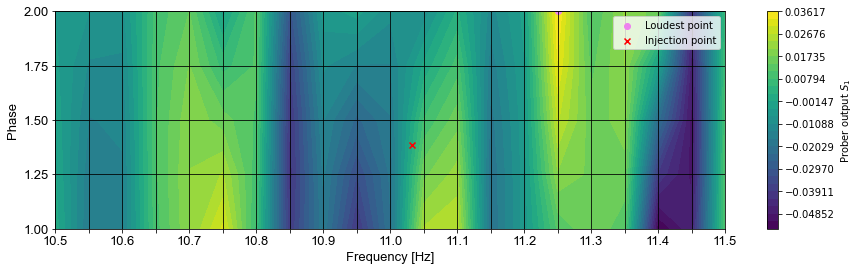

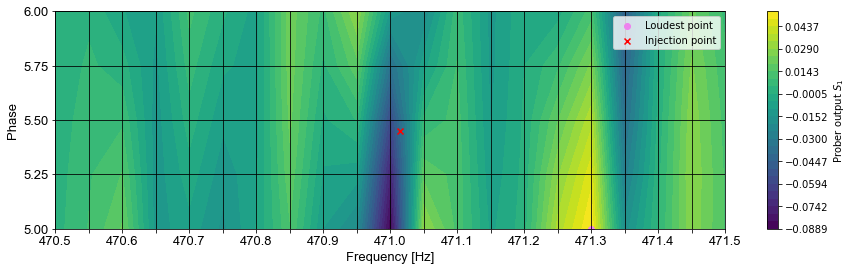

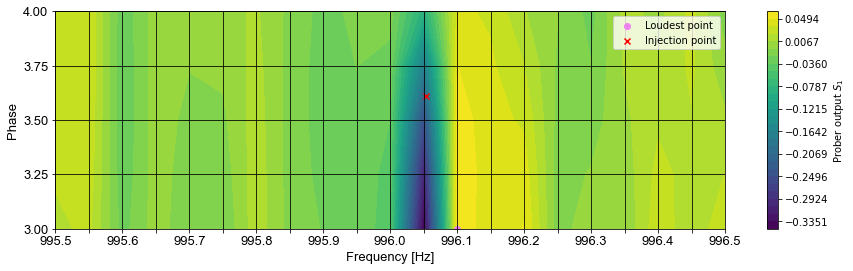

Search with template bank with N_df = 50


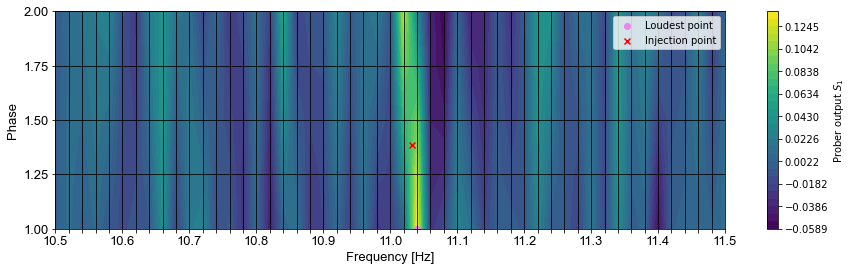

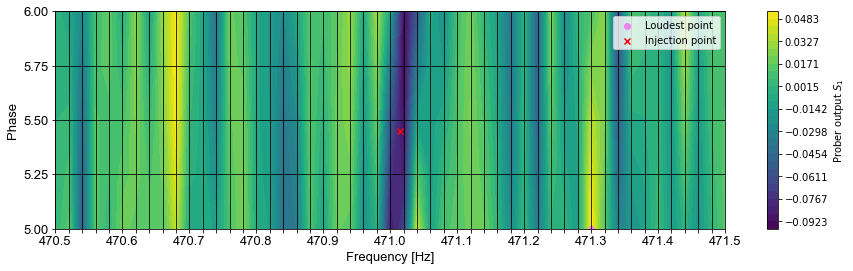

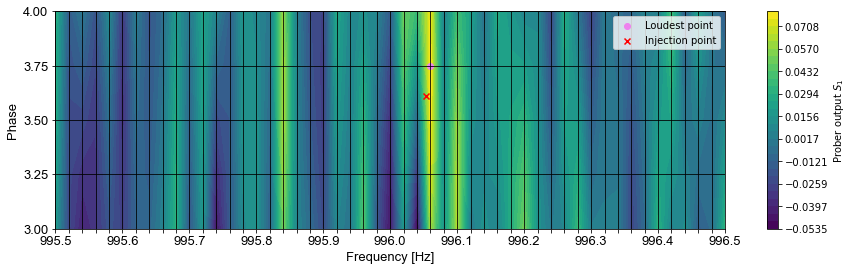

In [443]:
for i in range(len(fine_temp_bank_f_steps)):
    print(f"Search with template bank with N_df = {fine_temp_bank_f_steps[i]}")
    phase_freq_plot(result_list_1_fine_tb[i][16], freq=11.033, phase=1.387, N_df=fine_temp_bank_f_steps[i], f_min=10.5, f_max=11.5, mod=1, N_ph=4)
    phase_freq_plot(result_list_2_fine_tb[i][5], freq=471.015, phase=5.451, N_df=fine_temp_bank_f_steps[i], f_min=470.5, f_max=471.5, mod=1, N_ph=4)
    phase_freq_plot(result_list_3_fine_tb[i][39], freq=996.054, phase=3.612, N_df=fine_temp_bank_f_steps[i], f_min=995.5, f_max=996.5, mod=1, N_ph=4)
    

In [395]:
result_list_1_fine_tb_m2 = []
result_list_2_fine_tb_m2 = []
result_list_3_fine_tb_m2 = []
for i in range(len(fine_temp_banks_11)):
    result_list_1_fine_tb_m2.append(prober_for_list_template_bank(signals_1, fine_temp_banks_11[i], method = 2, output_file_name = f"signals_1_output_Nf_fine_m2_{str(fine_temp_bank_f_steps[i])}.txt"))
    result_list_2_fine_tb_m2.append(prober_for_list_template_bank(signals_2, fine_temp_banks_471[i], method = 2, output_file_name = f"signals_2_output_Nf_fine_m2_{str(fine_temp_bank_f_steps[i])}.txt"))
    result_list_3_fine_tb_m2.append(prober_for_list_template_bank(signals_3, fine_temp_banks_996[i], method = 2, output_file_name = f"signals_3_output_Nf_fine_m2_{str(fine_temp_bank_f_steps[i])}.txt"))
    

Search with template bank with N_df = 20


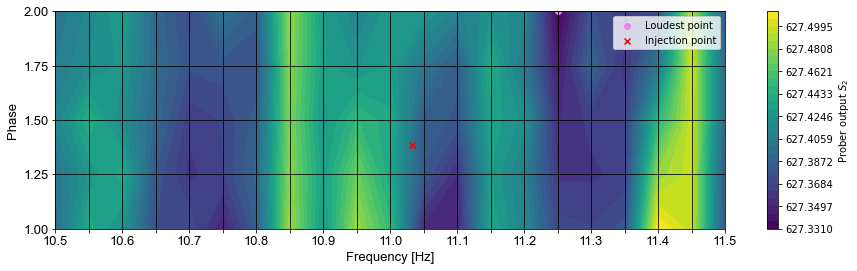

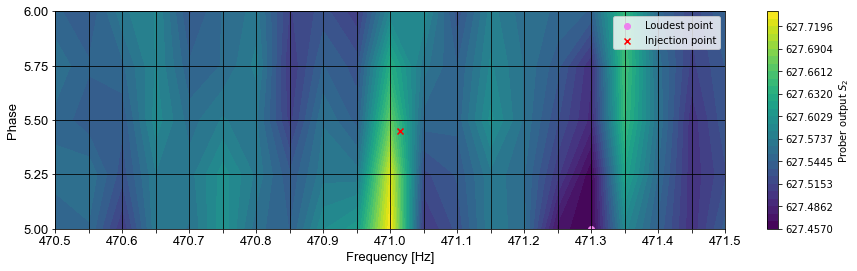

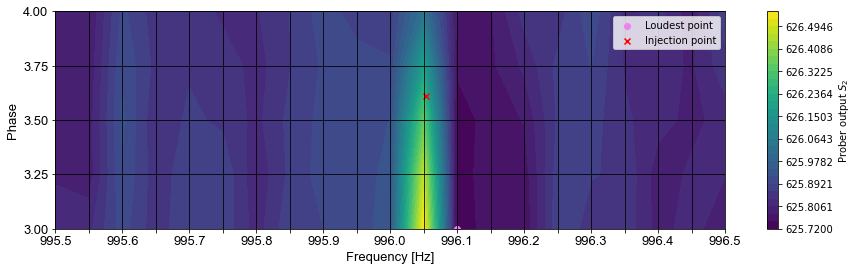

Search with template bank with N_df = 50


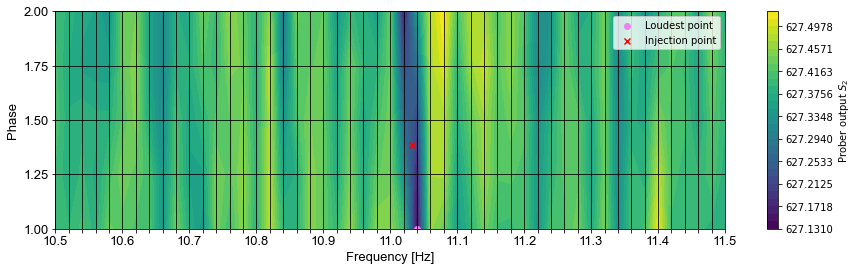

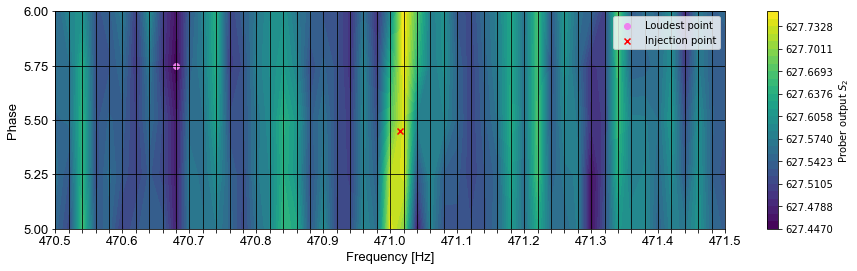

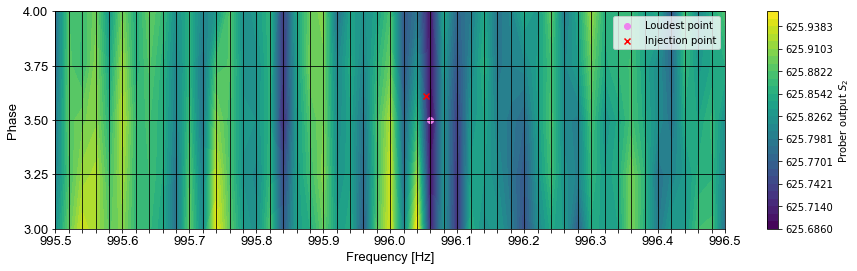

In [444]:
for i in range(len(fine_temp_bank_f_steps)):
    print(f"Search with template bank with N_df = {fine_temp_bank_f_steps[i]}")
    phase_freq_plot(result_list_1_fine_tb_m2[i][16], freq=11.033, phase=1.387, N_df=fine_temp_bank_f_steps[i], f_min=10.5, f_max=11.5, mod=2, N_ph=4)
    phase_freq_plot(result_list_2_fine_tb_m2[i][5], freq=471.015, phase=5.451, N_df=fine_temp_bank_f_steps[i], f_min=470.5, f_max=471.5, mod=2, N_ph=4)
    phase_freq_plot(result_list_3_fine_tb_m2[i][39], freq=996.054, phase=3.612, N_df=fine_temp_bank_f_steps[i], f_min=995.5, f_max=996.5, mod=2, N_ph=4)
    

In [69]:
temp_bank_f_steps = [10,20,25,50,100];

In [250]:
temp_banks_11 = []
temp_banks_471 = []
temp_banks_996 = []
for i in temp_bank_f_steps:
    temp_banks_11.append(generate_template_bank(11.0, 11.1, i, 1.0, 2.0, 4, f"template_bank_f11_{str(i)}.txt"))
    temp_banks_471.append(generate_template_bank(471.0, 471.1, i, 5.0, 6.0, 4, f"template_bank_f471_{str(i)}.txt"))
    temp_banks_996.append(generate_template_bank(996.0, 996.1, i, 3.0, 4.0, 4, f"template_bank_f996_{str(i)}.txt"))

For all of the template banks, each signal file is analysed using method 1. The paths of the result files are saved in one list per interval and per template bank.

In [251]:
result_list_1 = []
result_list_2 = []
result_list_3 = []
for i in range(len(temp_banks_11)):
    result_list_1.append(prober_for_list_template_bank(signals_1, temp_banks_11[i], method = 1, output_file_name = f"signals_1_output_Nf_{str(temp_bank_f_steps[i])}.txt"))
    result_list_2.append(prober_for_list_template_bank(signals_2, temp_banks_471[i], method = 1, output_file_name = f"signals_2_output_Nf_{str(temp_bank_f_steps[i])}.txt"))
    result_list_3.append(prober_for_list_template_bank(signals_3, temp_banks_996[i], method = 1, output_file_name = f"signals_3_output_Nf_{str(temp_bank_f_steps[i])}.txt"))
    

Search with template bank with N_df = 10


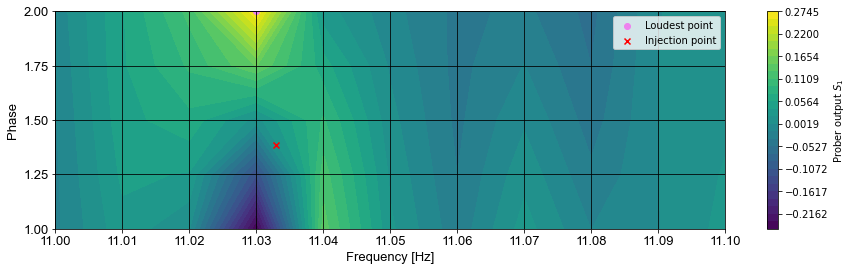

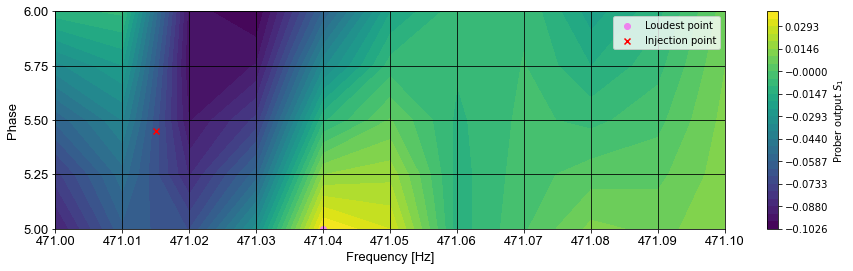

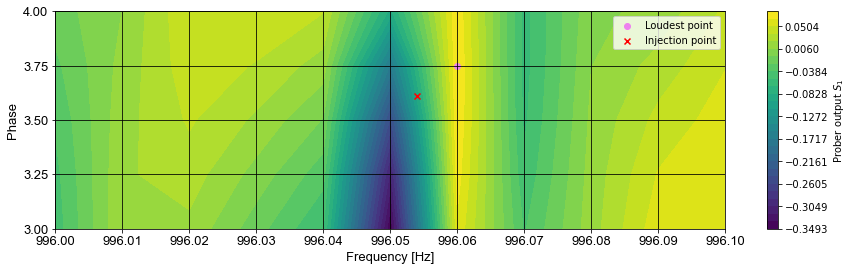

Search with template bank with N_df = 20


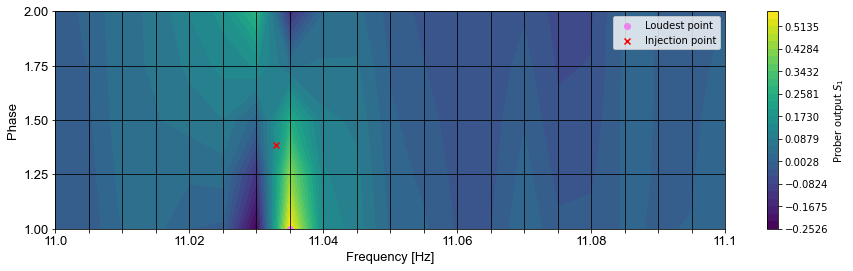

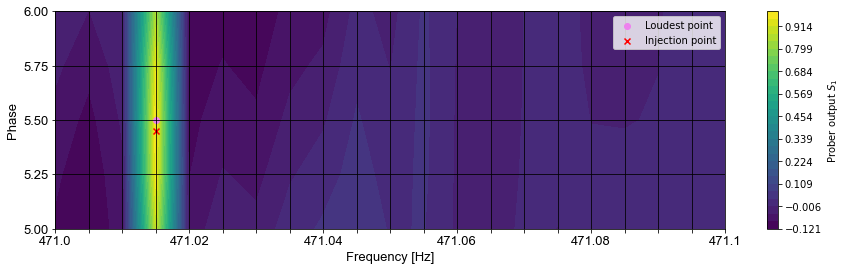

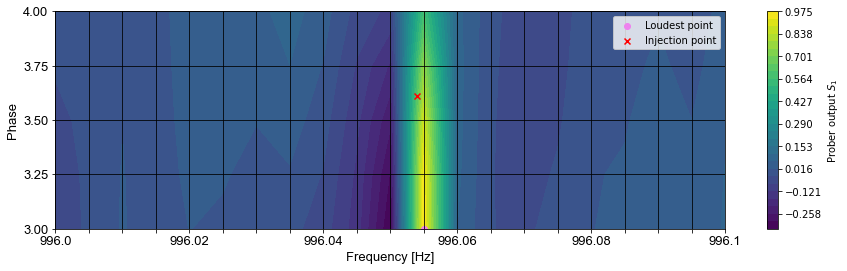

Search with template bank with N_df = 25


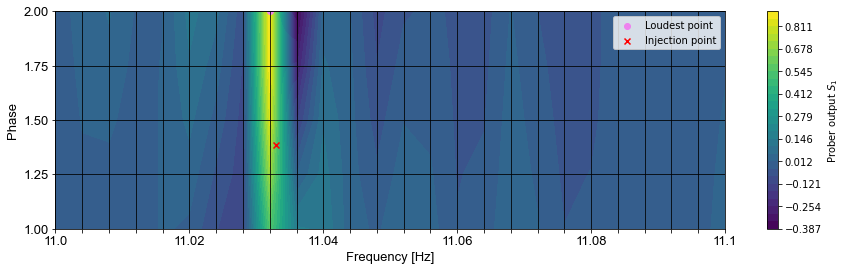

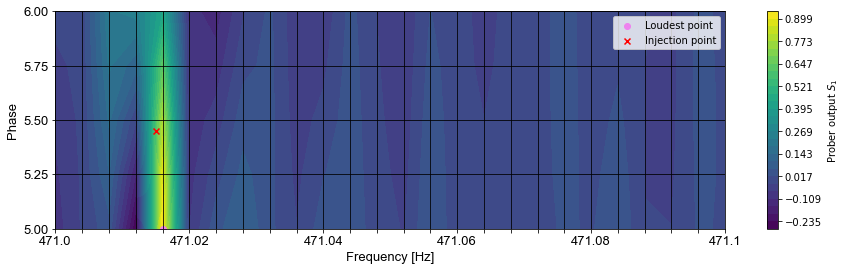

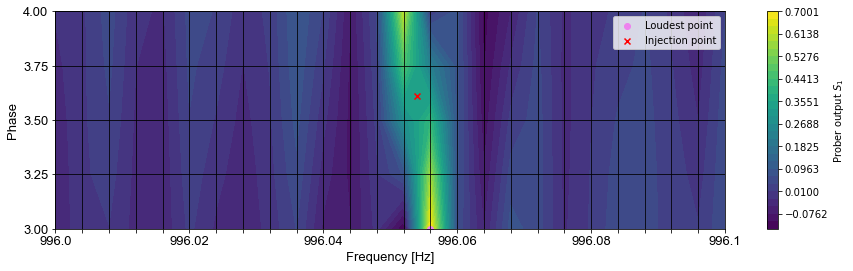

Search with template bank with N_df = 50


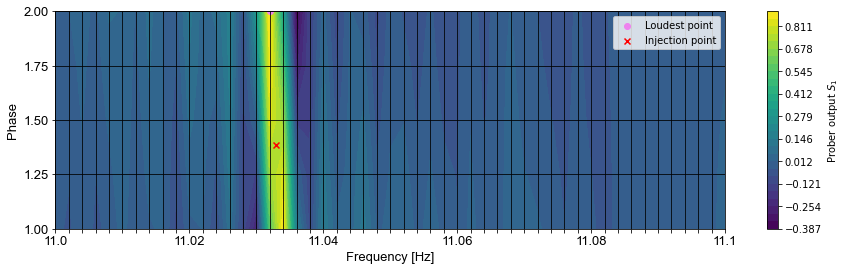

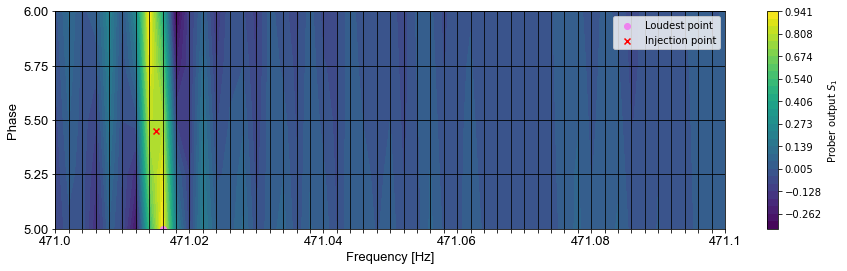

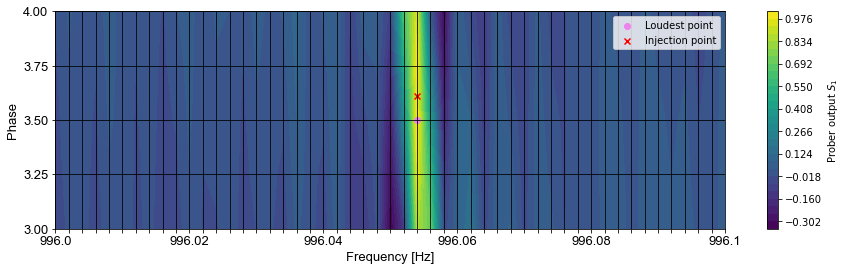

Search with template bank with N_df = 100


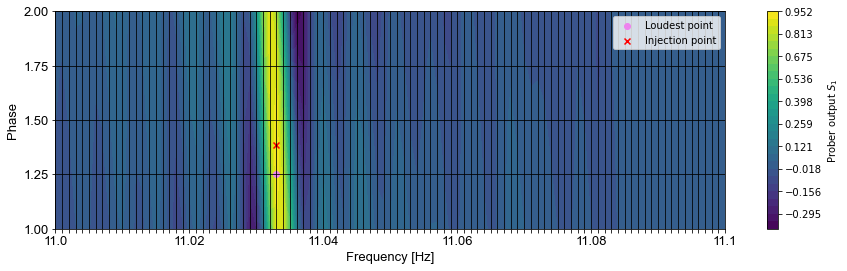

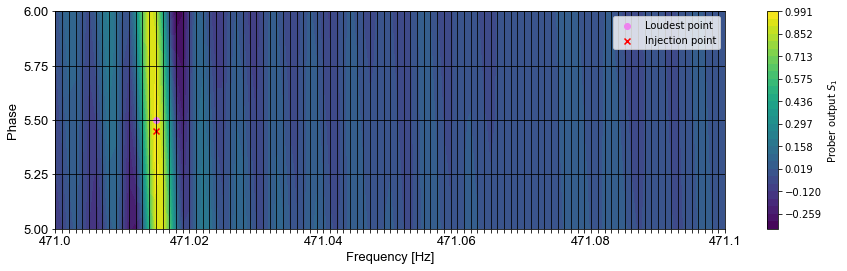

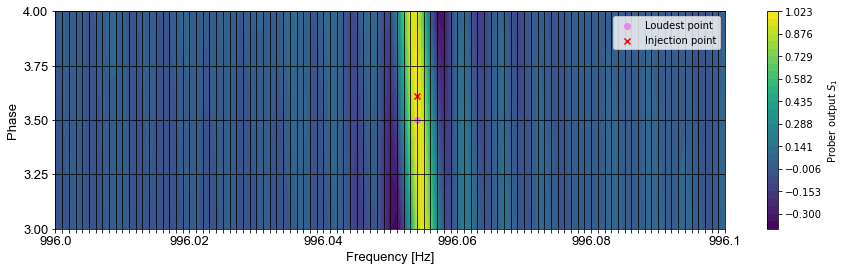

In [436]:
for i in range(len(temp_bank_f_steps)):
    print(f"Search with template bank with N_df = {temp_bank_f_steps[i]}")
    phase_freq_plot(result_list_1[i][16], freq=11.033, phase=1.387, N_df=temp_bank_f_steps[i], f_min=11, f_max=11.1, mod=1, N_ph=4, dx_axis_ticks = 0.02)
    phase_freq_plot(result_list_2[i][5], freq=471.015, phase=5.451, N_df=temp_bank_f_steps[i], f_min=471, f_max=471.1, mod=1, N_ph=4, dx_axis_ticks = 0.02)
    phase_freq_plot(result_list_3[i][39], freq=996.054, phase=3.612, N_df=temp_bank_f_steps[i], f_min=996, f_max=996.1, mod=1, N_ph=4, dx_axis_ticks = 0.02)
    

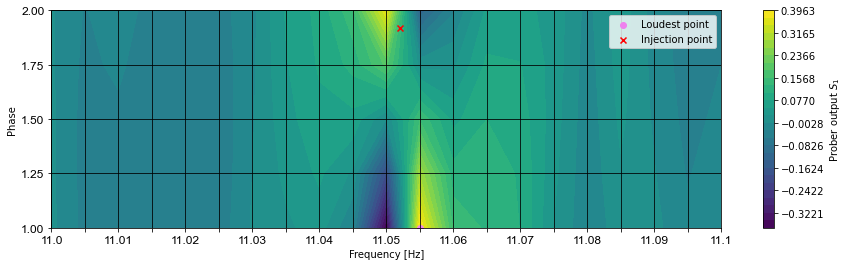

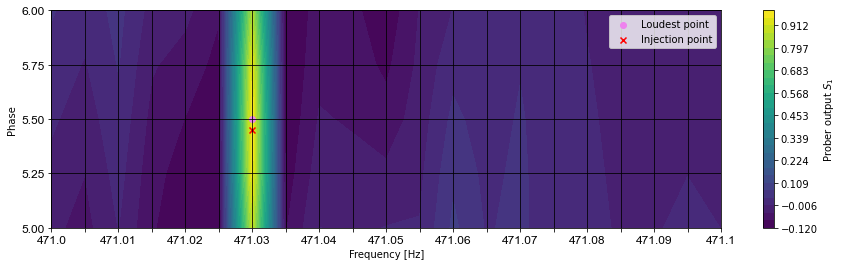

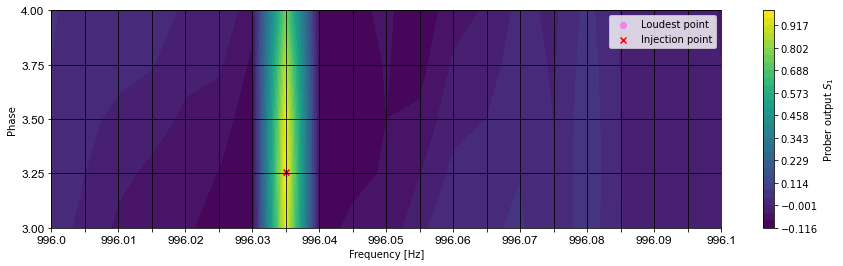

In [402]:
phase_freq_plot(result_list_1[1][0], freq=11.052, phase=1.921, N_df=temp_bank_f_steps[1], f_min=11, f_max=11.1, mod=1, N_ph=4)
phase_freq_plot(result_list_2[1][0], freq=471.03, phase=5.451, N_df=temp_bank_f_steps[1], f_min=471, f_max=471.1, mod=1, N_ph=4)
phase_freq_plot(result_list_3[1][0], freq=996.035, phase=3.258, N_df=temp_bank_f_steps[1], f_min=996, f_max=996.1, mod=1, N_ph=4)

In [399]:
result_list_1_m2 = []
result_list_2_m2 = []
result_list_3_m2 = []
for i in range(len(temp_banks_11)):
    result_list_1_m2.append(prober_for_list_template_bank(signals_1, temp_banks_11[i], method = 2, output_file_name = f"signals_1_output_Nf_{str(temp_bank_f_steps[i])}_m2.txt"))
    result_list_2_m2.append(prober_for_list_template_bank(signals_2, temp_banks_471[i], method = 2, output_file_name = f"signals_2_output_Nf_{str(temp_bank_f_steps[i])}_m2.txt"))
    result_list_3_m2.append(prober_for_list_template_bank(signals_3, temp_banks_996[i], method = 2, output_file_name = f"signals_3_output_Nf_{str(temp_bank_f_steps[i])}_m2.txt"))
    

Search with template bank with N_df = 10


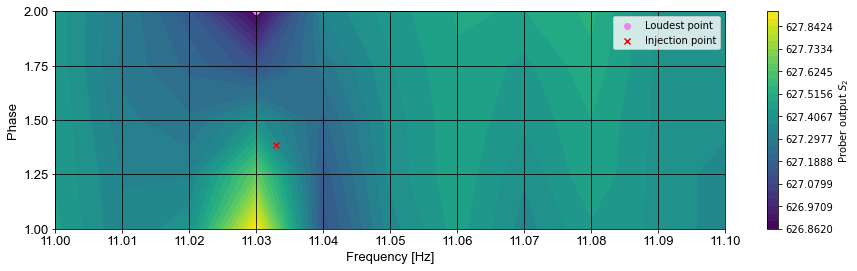

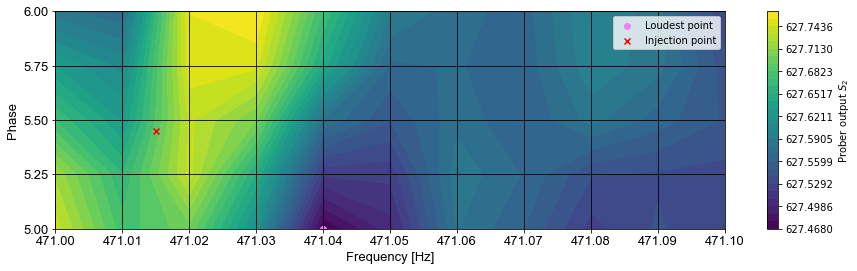

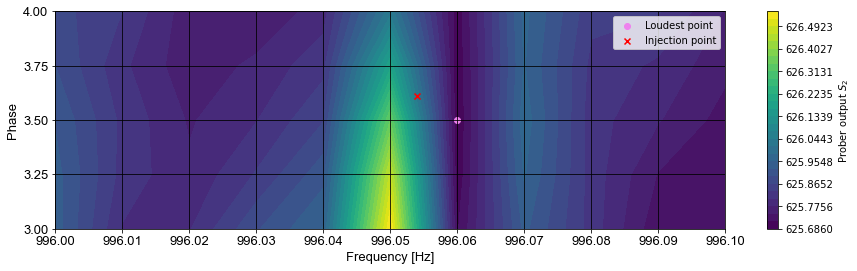

Search with template bank with N_df = 20


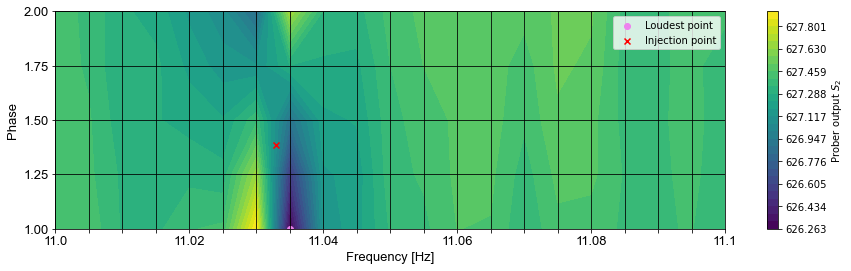

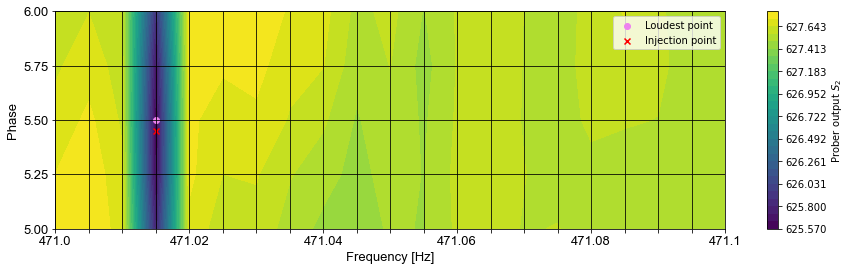

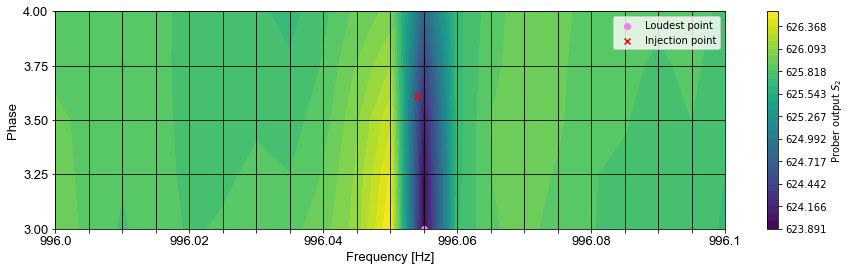

Search with template bank with N_df = 25


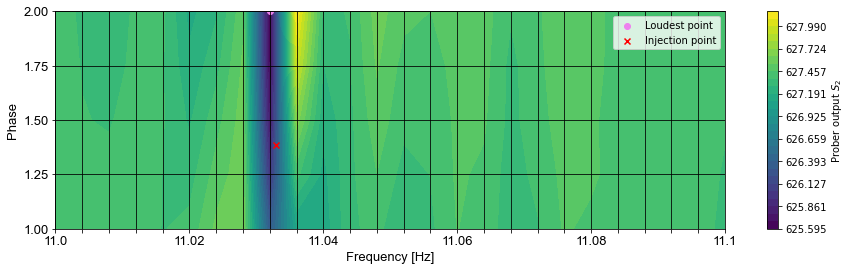

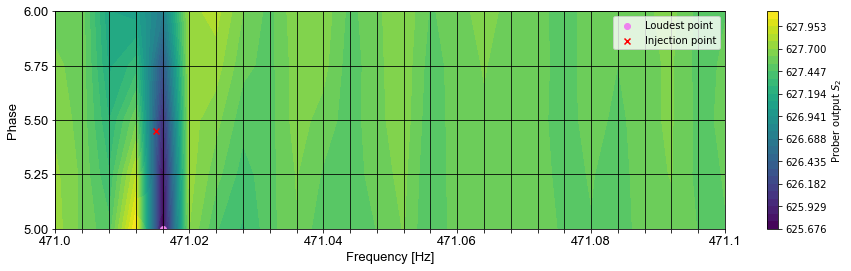

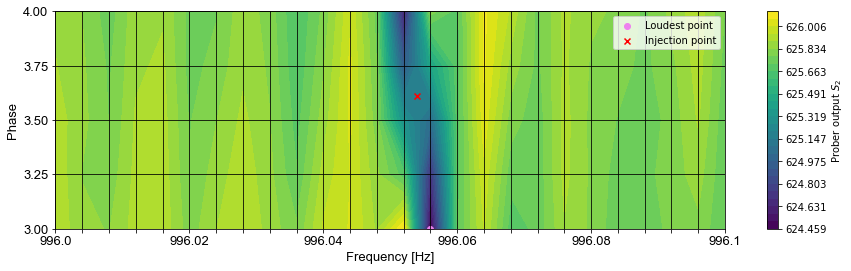

Search with template bank with N_df = 50


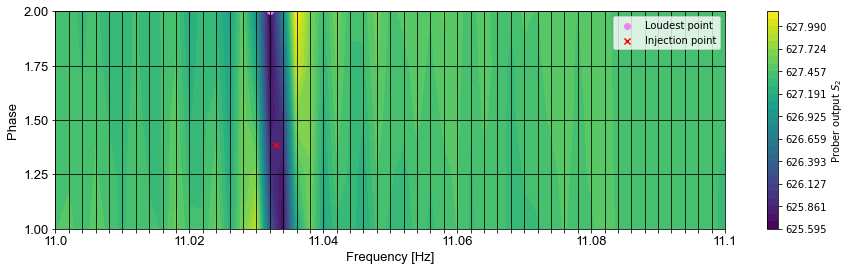

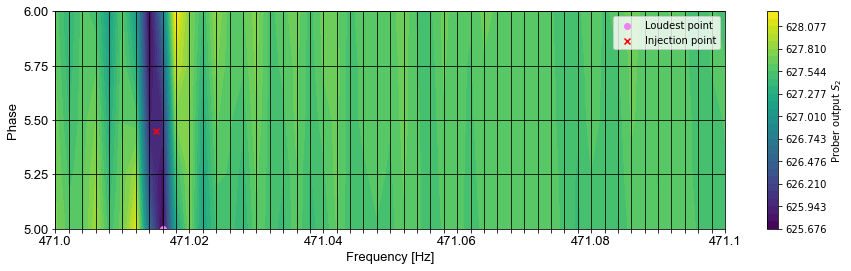

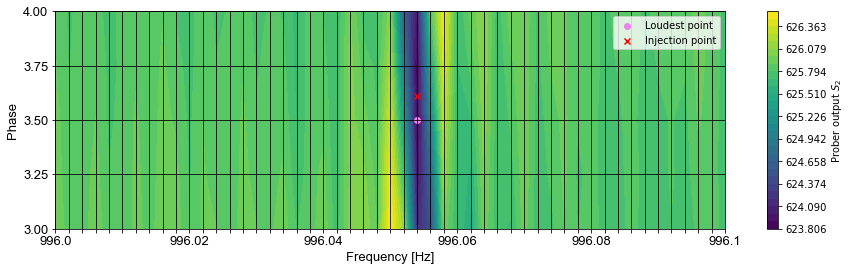

Search with template bank with N_df = 100


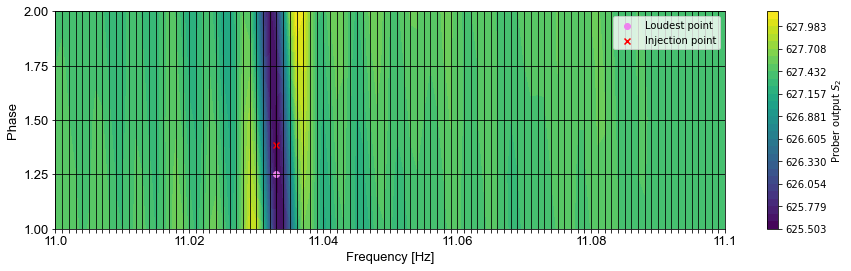

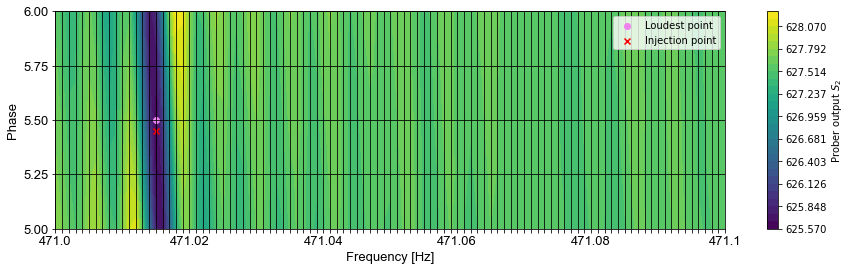

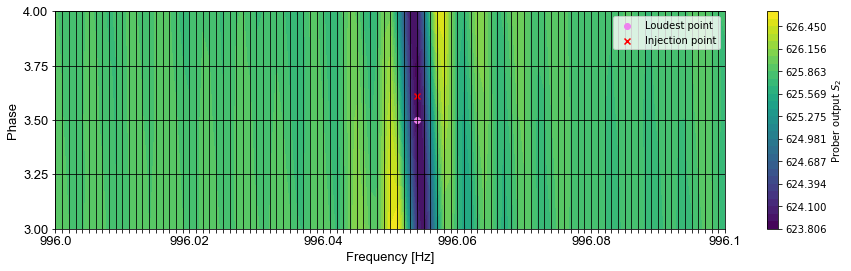

In [437]:
for i in range(len(temp_bank_f_steps)):
    print(f"Search with template bank with N_df = {temp_bank_f_steps[i]}")
    phase_freq_plot(result_list_1_m2[i][16], freq=11.033, phase=1.387, N_df=temp_bank_f_steps[i], f_min=11, f_max=11.1, mod=2, N_ph=4, dx_axis_ticks = 0.02)
    phase_freq_plot(result_list_2_m2[i][5], freq=471.015, phase=5.451, N_df=temp_bank_f_steps[i], f_min=471, f_max=471.1, mod=2, N_ph=4, dx_axis_ticks = 0.02)
    phase_freq_plot(result_list_3_m2[i][39], freq=996.054, phase=3.612, N_df=temp_bank_f_steps[i], f_min=996, f_max=996.1, mod=2, N_ph=4, dx_axis_ticks = 0.02)
    

For every degree of accuracy of the template banks, the difference df between the actual and the detected frequency is calculated, the same is done for the phases. Additionally, the mismatch $M = 1-S_1/S_0$ is computed, where $S_1$ is the best result of the analysis using a template bank and $S_0$ is the result when inserting the exact frequency and phase into prober. The values of df, dp and the mismatch are saved in five separate lists, one for each template bank. 

In [96]:
results_for_temp_bank_10, results_for_temp_bank_20, results_for_temp_bank_25, results_for_temp_bank_50, results_for_temp_bank_100 = [], [], [], [], []
results_setup = [results_for_temp_bank_10, results_for_temp_bank_20, results_for_temp_bank_25, results_for_temp_bank_50, results_for_temp_bank_100]
for i in range(len(results_setup)):
    for j in range(len(result_list_1[i])):
        phase_list_length = len(phase_list_1)
        f0 = freq_list_1[j//phase_list_length]
        p0 = phase_list_1[j%phase_list_length]
        s0 = prober_m12(signals_1[j], f=f0, phi=p0, mod=1)[2]
        prober_results_with_temp_bank = best_result_of_prober(result_list_1[i][j], 1)
        f1 = prober_results_with_temp_bank[0]
        p1 = prober_results_with_temp_bank[1]
        s1 = prober_results_with_temp_bank[2]
        df = abs(f1-f0)
        dp = abs(p1-p0)
        mismatch = abs(1-s1/s0)
        results_setup[i].append([df,dp,mismatch])

For each template bank the mean, minimum and maximum values of df, dp and the mismatch are calculated:

In [128]:
max_df_list, mean_df_list, max_dp_list, mean_dp_list, min_mismatch_list, max_mismatch_list, mean_mismatch_list = [], [], [], [], [], [], []
for i in range(len(results_setup)):
    max_df_list.append(max(np.array(results_setup)[i][:,0]))
    mean_df_list.append(mean(np.array(results_setup)[i][:,0]))
    max_dp_list.append(max(np.array(results_setup)[i][:,1]))
    mean_dp_list.append(mean(np.array(results_setup)[i][:,1]))
    min_mismatch_list.append(min(np.array(results_setup)[i][:,2]))
    max_mismatch_list.append(max(np.array(results_setup)[i][:,2]))
    mean_mismatch_list.append(mean(np.array(results_setup)[i][:,2]))

In [169]:
mismatch_df = pd.DataFrame([np.array(mean_df_list), np.array(max_df_list), np.array(mean_dp_list), np.array(max_dp_list), np.array(mean_mismatch_list), np.array(min_mismatch_list), np.array(max_mismatch_list)])
mismatch_df.columns = ["0.01", "0.005", "0.004", "0.002", "0.001" ]
mismatch_df.insert(0, "freq. steps [Hz]",["Mean df", "Max. df", "Mean dp", "Max. dp", "Mean mismatch", "Min. mismatch", "Max. mismatch"], True)
mismatch_df.head(7)

freq. steps [Hz]      0.01     0.005     0.004     0.002     0.001
0          Mean df  0.002500  0.001600  0.000900  0.000300  0.000000
1          Max. df  0.014000  0.003000  0.002000  0.001000  0.000000
2          Mean dp  0.457040  0.522560  0.388400  0.203560  0.100000
3          Max. dp  0.990000  0.990000  0.990000  0.613000  0.177000
4    Mean mismatch  0.380657  0.248818  0.103196  0.024284  0.006908
5    Min. mismatch  0.000109  0.000109  0.000059  0.000059  0.000010
6    Max. mismatch  0.947479  0.595853  0.312560  0.079573  0.027873

## Runtime analysis

In [542]:
source_runtime_analysis = generate_source(outputFile="source_runtime_analysis.txt", f=421.537, phi=1.63, A=0.5)

Runtime analysis for template bank with df = 0.005 Hz, dp = 0.25:

In [543]:
temp_bank_005_runtime = generate_template_bank(421.5, 421.6, 20, 0, 3, 12, f"template_bank_005_runtime.txt")

In [544]:
%%time
result_005_runtime = prober(inputFile = source_runtime_analysis, outputFile=f"output_005_runtime.txt",
                            templateFile=temp_bank_005_runtime, mod=1)       

CPU times: total: 0 ns
Wall time: 14.6 s


Runtime analysis for template bank with df = 0.004 Hz, dp = 0.25:

In [545]:
temp_bank_004_runtime = generate_template_bank(421.5, 421.6, 25, 0, 3, 12, f"template_bank_004_runtime.txt")

In [546]:
%%time
result_004_runtime = prober(inputFile = source_runtime_analysis, outputFile=f"output_004_runtime.txt",
                            templateFile=temp_bank_004_runtime, mod=1)       

CPU times: total: 0 ns
Wall time: 17.5 s


Runtime analysis for template bank with df = 0.002 Hz, dp = 0.25:

In [547]:
temp_bank_002_runtime = generate_template_bank(421.5, 421.6, 50, 0, 3, 12, f"template_bank_002_runtime.txt")

In [548]:
%%time
result_002_runtime = prober(inputFile = source_runtime_analysis, outputFile=f"output_002_runtime.txt",
                            templateFile=temp_bank_002_runtime, mod=1)       

CPU times: total: 15.6 ms
Wall time: 32.3 s


Runtime analysis for template bank with df = 0.001 Hz, dp = 0.25:

In [549]:
temp_bank_001_runtime = generate_template_bank(421.5, 421.6, 100, 0, 3, 12, f"template_bank_001_runtime.txt")

In [550]:
%%time
result_001_runtime = prober(inputFile = source_runtime_analysis, outputFile=f"output_001_runtime.txt",
                            templateFile=temp_bank_001_runtime, mod=1)       

CPU times: total: 15.6 ms
Wall time: 1min


## Testing method 3

Since method 3 will be used to filter for areas of interest before applying method 1, the Fourier spectra of multiple sources with signals similar to the ones to be detected are examined in order to determine a suitable threshold.

In [411]:
amplitude_list = [0.5, 1.0, 1.5, 2.0]
signals_varying_amplitude = []
for i in amplitude_list:
    signals_varying_amplitude.append(generate_source(outputFile=f"data_f243_5_p1_5_a{str(i).replace('.', '_')}.txt", f=243.5, phi=1.5, A=i, r=0))

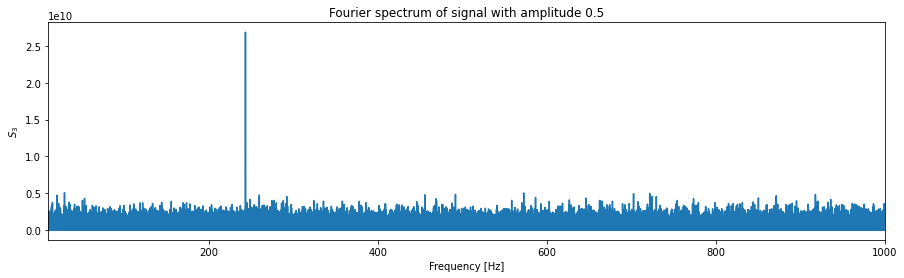

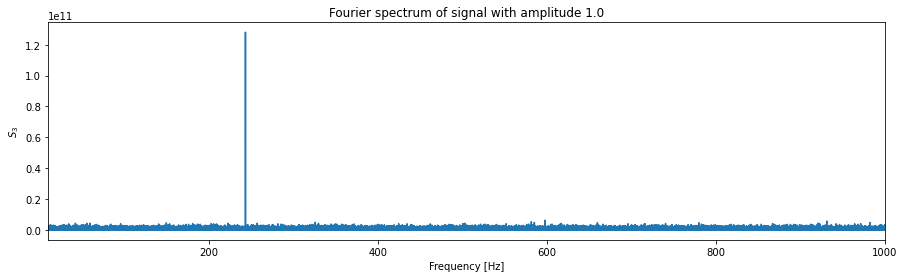

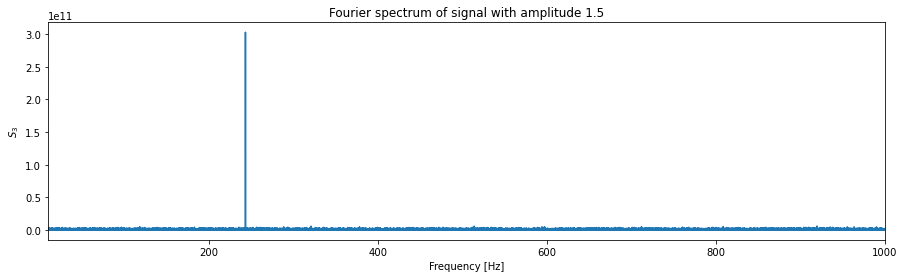

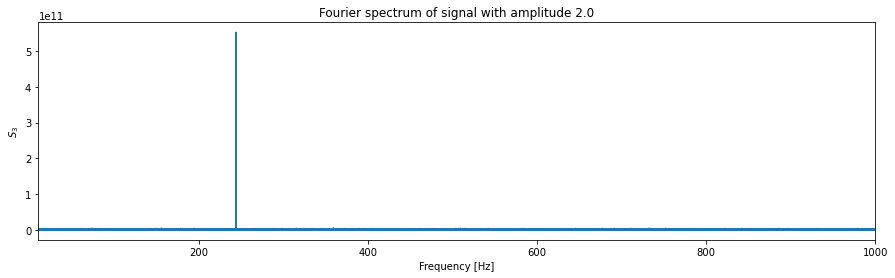

In [412]:
results_varying_amplitude = []
for i in range(len(amplitude_list)):
    prober_m3(signals_varying_amplitude[i], output_file = f"m3_result_amplitude{str(amplitude_list[i]).replace('.', '_')}.txt", fmin = 10, fmax = 1000, plot_title = f"Fourier spectrum of signal with amplitude {str(amplitude_list[i])}", save_fig_name = f"amplitude{str(amplitude_list[i]).replace('.', '_')}")
    results_varying_amplitude.append(os.path.join(data_dir, f"m3_result_amplitude{str(amplitude_list[i]).replace('.', '_')}.txt"))

### Find threshold for method 3

To determine a threshold to decide whether the result S$_3$ of method 3 of prober is assumend to be a signal or not, multiple sources with the minimum possible amplitude (A=0.5) and $\sigma = 25$ are generated. The frequency is the same for all of these sources while the phases are chosen randomly from the interval $[0, 2\pi]$. 

In [161]:
phase_list_s3_threshold = list(np.around(np.array(np.random.uniform(0, 2*np.pi, size=(1, 10)).flatten()),3));
freq_list_s3_threshold = list(np.around(np.array(np.random.uniform(10, 1000, size=(1, 20)).flatten()),3));
signals_s3_threshold = generate_sources_from_list(freq_list_s3_threshold, phase_list_s3_threshold, 0.5);
noise_s3_threshold = generate_sources_from_list(freq_list_s3_threshold, phase_list_s3_threshold, 2.0);

The sources are analysed using method 3 of prober and the maximum S$_3$ values are saved in a list:

In [162]:
signals_m3_results_list = []
noise_m3_results_list = []
max_s3_list_a05 = []
max_noise_s3_list = []
for i in range(200):
    # analyse data files using method 3 of prober
    signals_m3_results_list.append(prober(signals_s3_threshold[i], outputFile=f"signals_output_s3_{str(i+1)}.txt", mod=3))
    noise_m3_results_list.append(prober(noise_s3_threshold[i], outputFile=f"noise_output_s3_{str(i+1)}.txt", mod=3))
    # import results of prober
    m3_signals_result = np.loadtxt(signals_m3_results_list[i])
    m3_noise_result = np.loadtxt(noise_m3_results_list[i])
    # sort s3 values in ascending order
    sorted_s3_list_signals = np.argsort(m3_signals_result[:,2])
    sorted_s3_list_noise = np.argsort(m3_noise_result[:,2])
    # get index of largest and second largest s3 value
    max_s3_index = sorted_s3_list_signals[-1]
    max_noise_index = sorted_s3_list_noise[-2]
    # append maximum s3 to list with s3 values corresponding to signals
    max_s3_list_a05.append(m3_signals_result[:,2][max_s3_index])
    # append second largest s3 to list of maximum s3 results for noise   
    max_noise_s3_list.append(m3_noise_result[:,2][max_noise_index])

In [189]:
max_s3_list_a2 = []
for i in range(200):
    m3_signals_result_a2 = np.loadtxt(noise_m3_results_list[i])
    sorted_s3_list_signals_a2 = np.argsort(m3_signals_result_a2[:,2])
    max_s3_index_a2 = sorted_s3_list_signals_a2[-1]
    max_s3_list_a2.append(m3_signals_result_a2[:,2][max_s3_index_a2])

In [191]:
max_noise_s3_list_a05 = []
for i in range(200):
    m3_noise_result_a05 = np.loadtxt(signals_m3_results_list[i])
    sorted_s3_list_noise_a05 = np.argsort(m3_noise_result_a05[:,2])
    max_noise_index_a05 = sorted_s3_list_noise_a05[-2]
    max_noise_s3_list_a05.append(m3_noise_result_a05[:,2][max_noise_index_a05])

The resulting Fourier spectrum of one example of the sources looks like this:

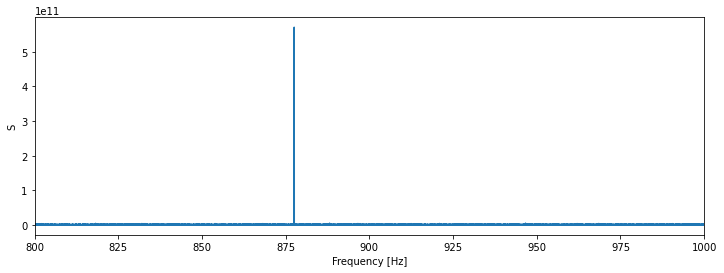

In [171]:
import_plot_data_m3(noise_m3_results_list[0], fmin = 800, fmax = 1000, plot_title = None)

In [167]:
mean_s3_noise = mean(max_noise_s3_list)
min_s3_noise = min(max_noise_s3_list)
max_s3_noise = max(max_noise_s3_list)

In [164]:
mean_s3 = mean(max_s3_list_a05)
min_s3 = min(max_s3_list_a05)
max_s3 = max(max_s3_list_a05)

In [165]:
mean_s3, min_s3, max_s3

(26785810000.0, 10205700000.0, 47811400000.0)

In [168]:
mean_s3_noise, min_s3_noise, max_s3_noise

(76142709950.0, 5273330000.0, 228856000000.0)

Plotting the ROC curve for method 3:

In [120]:
# To generate the ROC curve, the threshold to distinguish between noise/signal is varied.
# For the different thresholds, the true positive rate is plotted vs. the false positive rate.
def plot_roc_curve(noise_list, signal_list, n_a, method, plot_title = None, fig_name = None):
    
    # determine the range of s-values in the given files
    s_min = min([min(noise_list), min(signal_list)])
    s_max = max([max(noise_list), max(signal_list)])
    
    # get a list of threshold values
    a_list = np.linspace(s_min,s_max,n_a)
    
    # determine the true positive and false negative rate for all thresholds 
    # save the results in two lists: false positive list, true positive list
    
    N_noise = len(noise_list)
    N_signal = len(signal_list)
    
    false_positive_list = []
    true_positive_list = []
    
    for i in range(len(a_list)):
        fp_count = 0
        tp_count = 0
        for j in range(N_noise):
            if (method == 1 or method == 3) and noise_list[j] > a_list[i]:
                fp_count += 1
            elif method == 2 and noise_list[j] < a_list[i]:
                fp_count +=1
                
        false_positive_list.append(fp_count/N_noise)
            
        for k in range(N_signal):
            if (method == 1 or method == 3) and signal_list[k] > a_list[i]:
                tp_count += 1
            elif method == 2 and signal_list[k] < a_list[i]:
                tp_count +=1
                
        true_positive_list.append(tp_count/N_signal)
            
    result_list = []
    for n in range(len(a_list)):
        result_list.append([a_list[n], true_positive_list[n], false_positive_list[n]])
        
    
    plt.plot(false_positive_list, true_positive_list)
    plt.xlabel("False positive rate", fontname="Arial", fontsize=13)
    plt.ylabel("True positive rate", fontname="Arial", fontsize=13)
    plt.xticks(fontname="Arial", fontsize=13)
    plt.yticks(fontname="Arial", fontsize=13)
    
    if plot_title:
        plt.title("ROC curve: " + plot_title)
    #else: 
        #plt.title("ROC curve")
        
    plt.savefig(f"ROC_curve_mod{str(method)}_{fig_name}.png", dpi=800)
    plt.show()
        
    return result_list

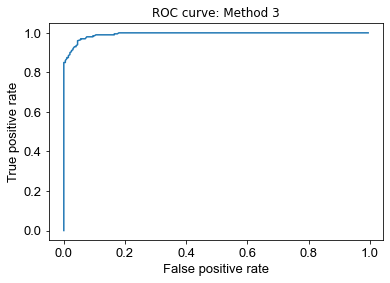

[[5150160000.0, 1.0, 0.995],
 [5235653466.933867, 1.0, 0.985],
 [5321146933.867736, 1.0, 0.98],
 [5406640400.801603, 1.0, 0.97],
 [5492133867.735471, 1.0, 0.965],
 [5577627334.669338, 1.0, 0.925],
 [5663120801.603207, 1.0, 0.89],
 [5748614268.537074, 1.0, 0.87],
 [5834107735.470942, 1.0, 0.8],
 [5919601202.40481, 1.0, 0.74],
 [6005094669.338677, 1.0, 0.685],
 [6090588136.272545, 1.0, 0.655],
 [6176081603.206413, 1.0, 0.605],
 [6261575070.140281, 1.0, 0.575],
 [6347068537.074148, 1.0, 0.525],
 [6432562004.008017, 1.0, 0.485],
 [6518055470.941884, 1.0, 0.445],
 [6603548937.8757515, 1.0, 0.42],
 [6689042404.809619, 1.0, 0.4],
 [6774535871.743487, 1.0, 0.39],
 [6860029338.677355, 1.0, 0.38],
 [6945522805.611222, 1.0, 0.36],
 [7031016272.54509, 1.0, 0.355],
 [7116509739.478958, 1.0, 0.34],
 [7202003206.412826, 1.0, 0.33],
 [7287496673.346693, 1.0, 0.32],
 [7372990140.280561, 1.0, 0.305],
 [7458483607.214429, 1.0, 0.3],
 [7543977074.148296, 1.0, 0.3],
 [7629470541.082165, 1.0, 0.285],
 [7714

In [193]:
plot_roc_curve(max_noise_s3_list_a05, max_s3_list_a05, 500, method = 3, plot_title = "Method 3", fig_name = None)

## Find frequencies with method 3

In [17]:
# imports the data in file (should be result of method 3 of prober)
# plots the Fourier spectrum in the given frequency range
def prober_m3(input_file, output_file = None, fmin = 10, fmax = 1000, y_max = None, plot_title = None, save_fig_name = None):
    
    result_file = prober(input_file, outputFile=output_file, mod=3)
    
    plot_data = np.loadtxt(result_file)
    freq_list = plot_data[:,0]
    s3_list = plot_data[:,2]
    
    plt.figure(figsize = (15,4))
    plt.plot(freq_list,s3_list)
   
    plt.xlim(fmin, fmax)
    plt.xlabel("Frequency [Hz]", fontname="Arial", fontsize=13)
    plt.ylabel("$S_3$", fontname="Arial", fontsize=13)
    
    plt.xticks(fontname="Arial", fontsize=13)
    plt.yticks(fontname="Arial", fontsize=13)
        
    if y_max:
        plt.ylim(0, y_max)
    
    
    if plot_title:
        plt.title(plot_title)
        
    if save_fig_name != None:
        plt.savefig(f"m3_result_{save_fig_name}.png", dpi=800)
    
    plt.show()
    
    return

In [18]:
data_to_analyse = []
for i in range(5):
    data_to_analyse.append(os.path.join(data_dir, f"data_0{str(i+1)}.csv"))

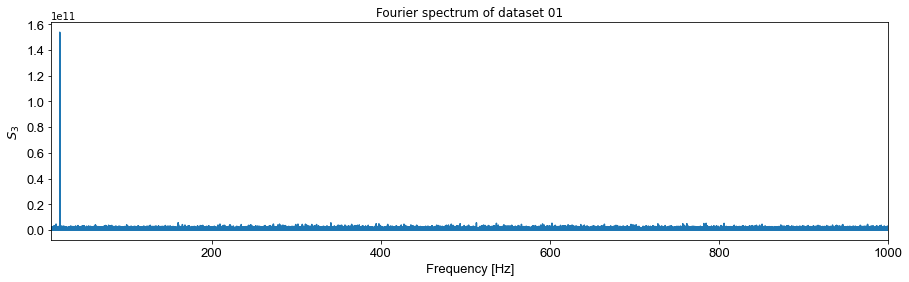

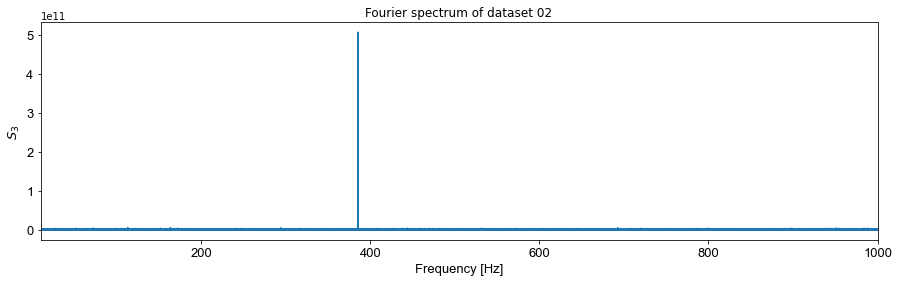

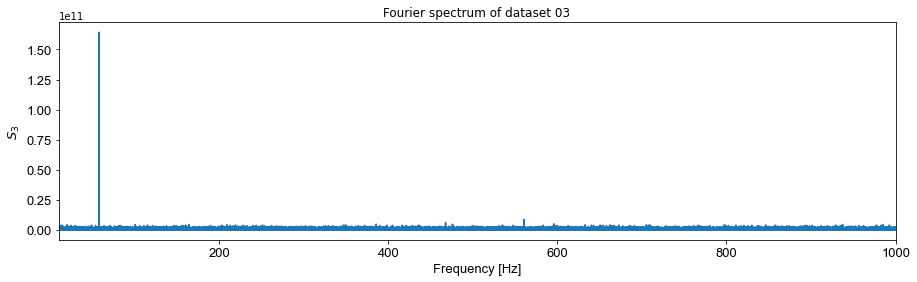

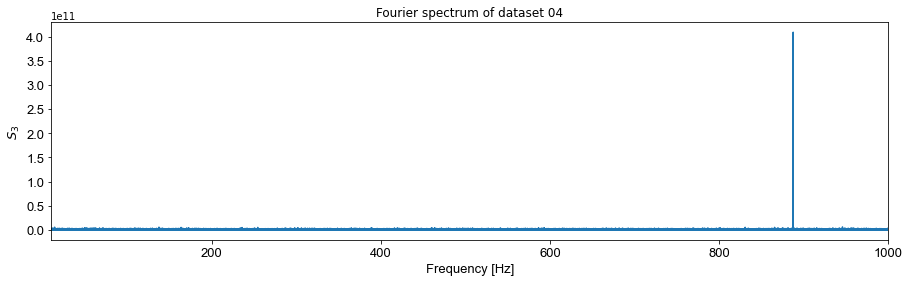

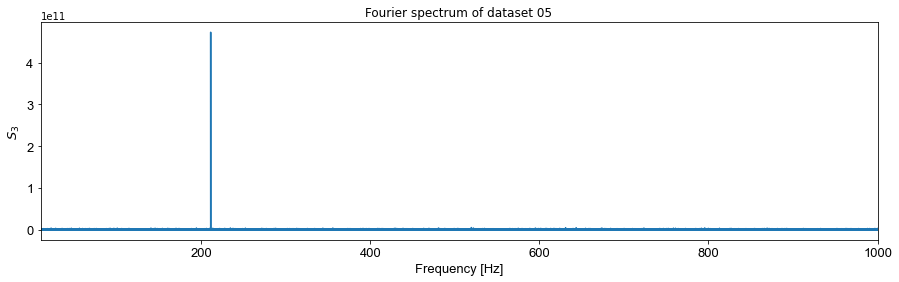

In [19]:
m3_results_data = []
for i in range(5):
    prober_m3(data_to_analyse[i], output_file = f"m3_result_data_0{str(i+1)}.txt", fmin = 10, fmax = 1000, plot_title = f"Fourier spectrum of dataset 0{str(i+1)}", save_fig_name = f"data_0{str(i+1)}")
    m3_results_data.append(os.path.join(data_dir, f"m3_result_data_0{str(i+1)}.txt"))

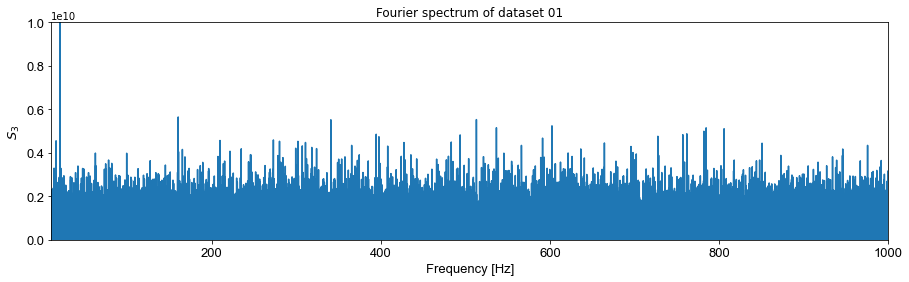

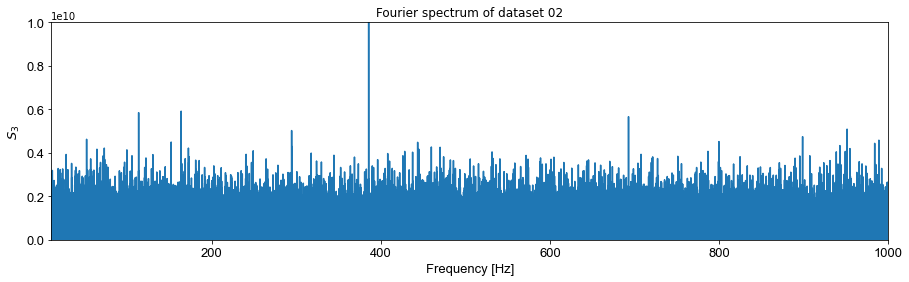

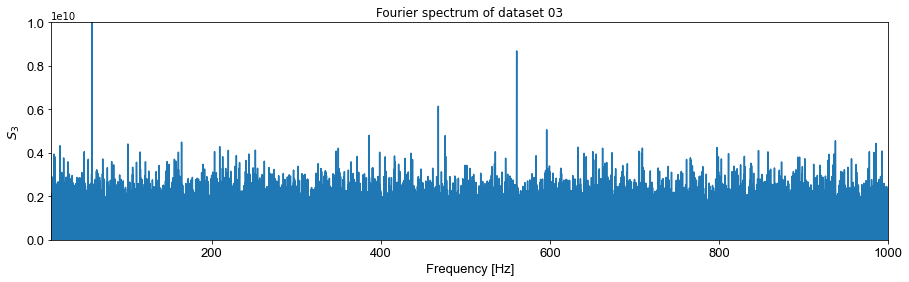

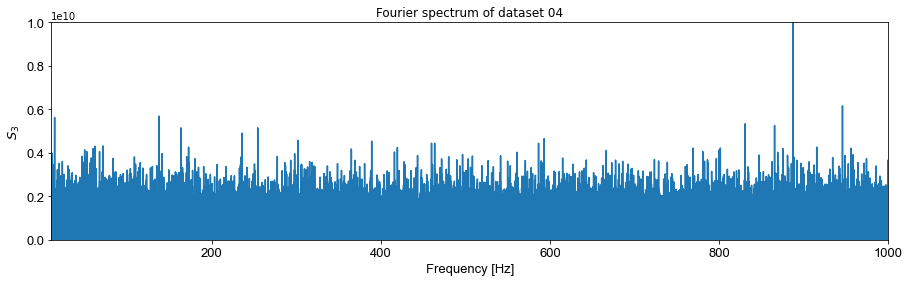

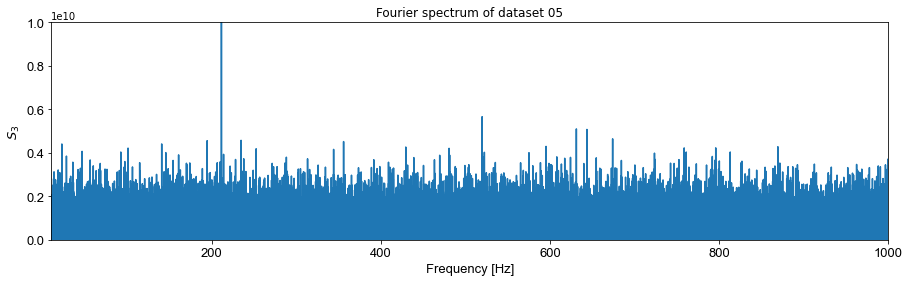

In [442]:
for i in range(5):
    prober_m3(data_to_analyse[i], output_file = f"m3_result_data_0{str(i+1)}.txt", fmin = 10, fmax = 1000, y_max = 1.0e10, plot_title = f"Fourier spectrum of dataset 0{str(i+1)}", save_fig_name = f"data_0{str(i+1)}_ymax_1e10")


In [589]:
# return all values of s3 larger than or equal to the input threshold, together with the corresponding frequency
def s3_above_threshold_and_frequencies(file, s3_threshold):
    input_data = np.loadtxt(file)
    freq_list = input_data[:,0]
    s3_list = input_data[:,2]
    
    result_list = []
    
    for i in range(len(freq_list)):
        f_i = freq_list[i]
        s3_i = s3_list[i]
        if f_i > 1000:
            break
        elif s3_i >= s3_threshold:
            result_list.append([f_i, s3_i])
    
    return result_list

The areas of interest for the following stages of the search are determined by extracting all peaks of the Fourier spectra that are above 5.6e+09.

In [211]:
above_threshold_data_01 = s3_above_threshold_and_frequencies(m3_results_data[0], 5.6e+09)
above_threshold_data_02 = s3_above_threshold_and_frequencies(m3_results_data[1], 5.6e+09)
above_threshold_data_03 = s3_above_threshold_and_frequencies(m3_results_data[2], 5.6e+09)
above_threshold_data_04 = s3_above_threshold_and_frequencies(m3_results_data[3], 5.6e+09)
above_threshold_data_05 = s3_above_threshold_and_frequencies(m3_results_data[4], 5.6e+09)

In [212]:
above_threshold_data_01

[[20.0033, 153801000000.0], [160.099, 5648290000.0]]

In [213]:
above_threshold_data_02

[[113.308, 5847850000.0],
 [163.599, 5914840000.0],
 [385.364, 506506000000.0],
 [692.737, 5662160000.0]]

In [214]:
above_threshold_data_03

[[57.9708, 17150100000.0],
 [57.9763, 164313000000.0],
 [57.9819, 89873100000.0],
 [57.9874, 9968800000.0],
 [57.993, 7844790000.0],
 [57.9985, 6868180000.0],
 [467.744, 6141450000.0],
 [560.465, 8685920000.0]]

In [217]:
mean([57.9708, 57.9763, 57.9819, 57.9874, 57.993, 57.9985])

57.98465

In [215]:
above_threshold_data_04

[[13.9579, 5630510000.0],
 [137.34, 5689460000.0],
 [887.503, 7103430000.0],
 [887.509, 15490200000.0],
 [887.514, 409024000000.0],
 [887.52, 56750400000.0],
 [887.525, 8732320000.0],
 [945.791, 6157140000.0]]

In [218]:
mean([887.503, 887.509, 887.514, 887.52, 887.525])

887.5142

In [216]:
above_threshold_data_05

[[211.207, 6341800000.0],
 [211.213, 40824400000.0],
 [211.218, 472570000000.0],
 [211.224, 14650500000.0],
 [211.23, 14073000000.0],
 [519.575, 5661130000.0]]

In [219]:
mean([211.207, 211.213, 211.218, 211.224, 211.23])

211.2184

In [220]:
m3_frequencies_data_01 = np.array(above_threshold_data_01)[:,0]
m3_frequencies_data_02 = np.array(above_threshold_data_02)[:,0]
m3_frequencies_data_03 = [57.98, 467.744 , 560.465]
m3_frequencies_data_04 = [13.9579, 137.34, 887.51 , 945.791]
m3_frequencies_data_05 = [211.22 , 519.575]

## Search with method 1

In [221]:
# generates a list of template bank file paths 
# the template banks are centered around the frequencies in the input list and span the given range of frequencies
def generate_template_bank_list(freq_list, f_range, N_df, phase_steps = 6):
    file_paths = []
    for i in range(len(freq_list)):
        freq = freq_list[i]
        file_paths.append(generate_template_bank(freq - f_range/2, freq + f_range/2, N_df, 0, 2*np.pi, phase_steps, 
                                                 f"temp_bank_f{str(freq).replace('.', '_')}_Df{str(f_range).replace('.', '_')}.txt"))
        
    return file_paths

In [261]:
# return all results of prober for the templates with s-values above (for mod 1) or below (for mod 2) the threshold
def prober_with_tb_above_threshold(prober_result_file, threshold, method = 1):
    
    result_data = np.loadtxt(prober_result_file)
    s_list = result_data[:,2]
    index_list = []
    best_results = []
    
    if method == 1:
        for i in range(len(s_list)):
            if s_list[i] >= threshold:
                best_results.append(result_data[i])
             
    elif method == 2:
        for i in range(len(s_list)):
            if s_list[i] <= threshold:
                best_results.append(result_data[i])
            
    else:
        print("This is not a valid method, use method 1 or 2.")
        return
    
    
    return best_results
    

In [37]:
# returns the minimum frequency of the input template bank file
def min_freq_of_tb(template_bank):
    
    freq_list = np.loadtxt(template_bank)[:,0]
    
    return min(freq_list)

In [38]:
# returns the maximum frequency of the input template bank file
def max_freq_of_tb(template_bank):
    
    freq_list = np.loadtxt(template_bank)[:,0]
    
    return max(freq_list)

Generating the template banks for dataset 1:

In [222]:
temp_banks_data_01_stage1 = generate_template_bank_list(m3_frequencies_data_01, 5, 1000, phase_steps = 6)

Analyse data 01 with method 1 and 2 of prober, using the template banks generated above:

In [227]:
data_01_results_m1_tb_stage1 = []
data_01_results_m2_tb_stage1 = []
for i in range(len(temp_banks_data_01_stage1)):
    data_01_results_m1_tb_stage1.append(prober(data_to_analyse[0], outputFile=f"result_01_f{str(m3_frequencies_data_01[i]).replace('.', '_')}_stage1_m1.txt", 
                                            templateFile=temp_banks_data_01_stage1[i], mod=1))
    data_01_results_m2_tb_stage1.append(prober(data_to_analyse[0], outputFile=f"result_01_f{str(m3_frequencies_data_01[i]).replace('.', '_')}_stage1_m2.txt", 
                                            templateFile=temp_banks_data_01_stage1[i], mod=2))

In [64]:
get_best_result(data_01_results_m1_tb_005[0], method = 1)

array([19.9983 ,  1.0472 ,  0.45287])

In [344]:
prober_with_tb_above_threshold(data_01_results_m1_tb_stage1[0], 0.075, method = 1)

[array([18.4083   ,  4.18879  ,  0.0783035]),
 array([19.9933   ,  0.       ,  0.0847647]),
 array([19.9933   ,  1.0472   ,  0.0900528]),
 array([19.9933   ,  6.28319  ,  0.0847648]),
 array([19.9983  ,  0.      ,  0.265497]),
 array([19.9983 ,  1.0472 ,  0.45287]),
 array([19.9983  ,  2.0944  ,  0.187378]),
 array([19.9983  ,  6.28319 ,  0.265497]),
 array([20.0033  ,  3.14159 ,  0.101036]),
 array([20.0033  ,  4.18879 ,  0.263772]),
 array([20.0033  ,  5.23599 ,  0.162738]),
 array([20.0083  ,  4.18879 ,  0.112776]),
 array([20.0083   ,  5.23599  ,  0.0900292])]

Plot the results in frequency-phase contour plots:

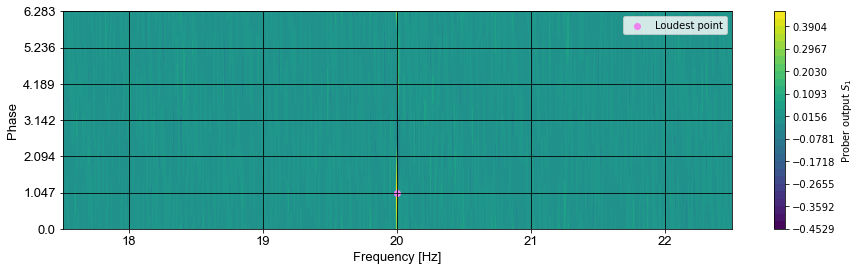

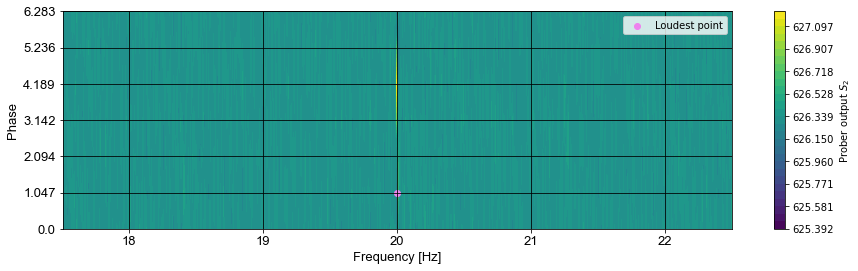

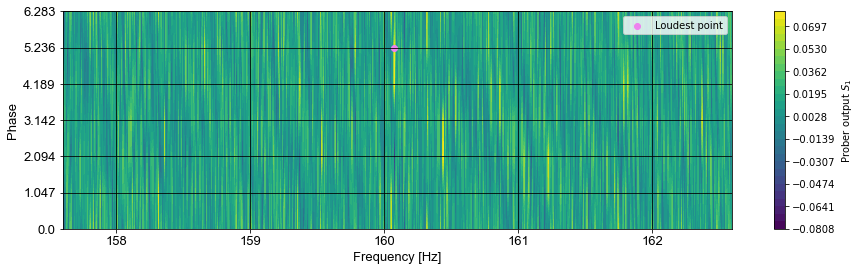

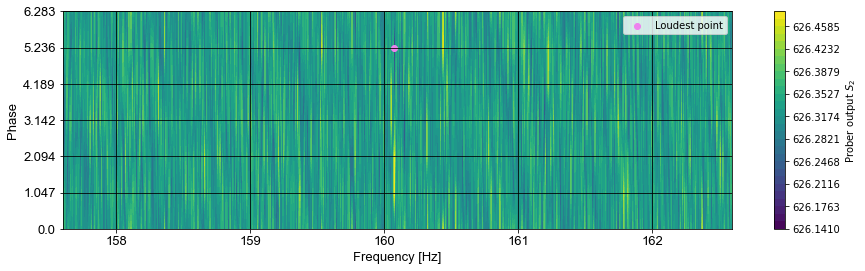

In [256]:
for i in range(len(temp_banks_data_01_stage1)):
    freq_list = np.loadtxt(temp_banks_data_01_stage1[i])[:,0]
    f_min_1 = min(freq_list)
    f_max_1 = max(freq_list)
    phase_freq_plot(data_01_results_m1_tb_stage1[i],freq=None, phase=None, N_df=1000, f_min=f_min_1, f_max=f_max_1, mod=1, 
                    N_ph=6, dx_axis_ticks = 0.02, fig_file_name = f"data_01_stage1_{str(i)}")
    phase_freq_plot(data_01_results_m2_tb_stage1[i],freq=None, phase=None, N_df=1000, f_min=f_min_1, f_max=f_max_1, mod=2, 
                    N_ph=6, dx_axis_ticks = 0.02, fig_file_name = f"data_01_stage1_{str(i)}")

Generating the template banks for dataset 2:

In [223]:
temp_banks_data_02_stage1 = generate_template_bank_list(m3_frequencies_data_02, 5, 1000, phase_steps = 6)

Analyse data 02 with method 1 and 2 of prober, using the template banks generated above:

In [228]:
%%time
data_02_results_m1_tb_stage1 = []
data_02_results_m2_tb_stage1 = []
for i in range(len(temp_banks_data_02_stage1)):
    data_02_results_m1_tb_stage1.append(prober(data_to_analyse[1], outputFile=f"result_02_f{str(m3_frequencies_data_02[i]).replace('.', '_')}_stage1_m1.txt", 
                                            templateFile=temp_banks_data_02_stage1[i], mod=1))
    data_02_results_m2_tb_stage1.append(prober(data_to_analyse[1], outputFile=f"result_02_f{str(m3_frequencies_data_02[i]).replace('.', '_')}_stage1_m2.txt", 
                                            templateFile=temp_banks_data_02_stage1[i], mod=2))

CPU times: total: 46.9 ms
Wall time: 52min 50s


In [75]:
get_best_result(data_02_results_m1_tb_005[3], method = 1)

array([385.299   ,   2.0944  ,   0.921301])

In [333]:
prober_with_tb_above_threshold(data_02_results_m1_tb_stage1[3], 0.075, method = 1)

[array([6.92622e+02, 3.14159e+00, 9.95122e-02])]

Plot the results in frequency-phase contour plots:

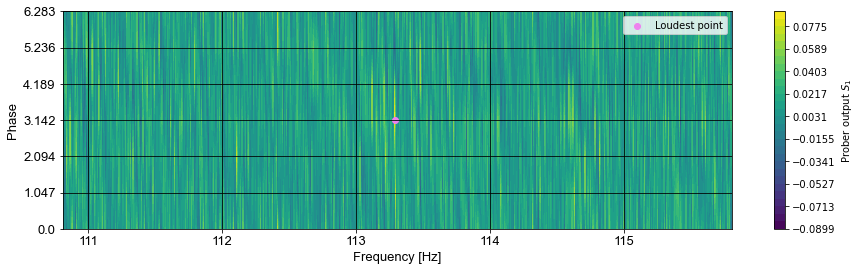

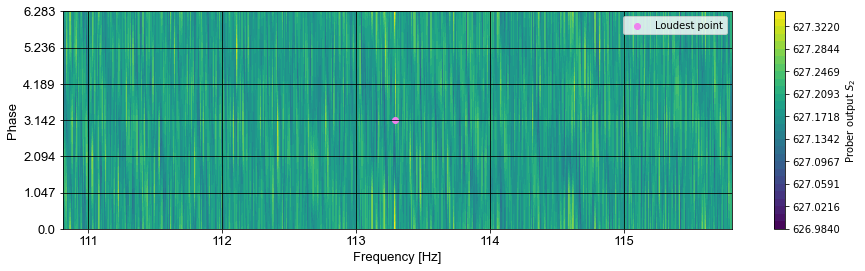

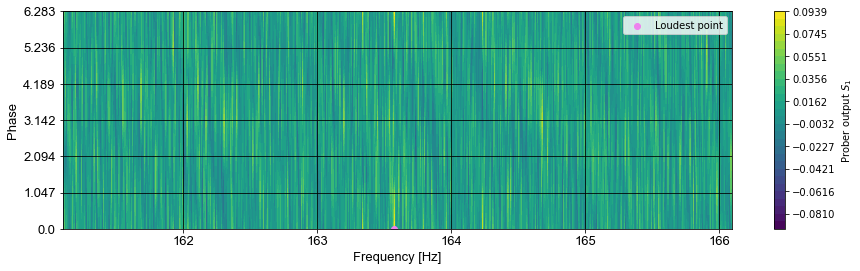

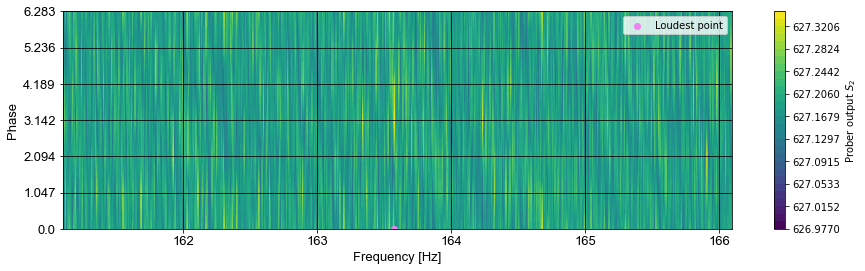

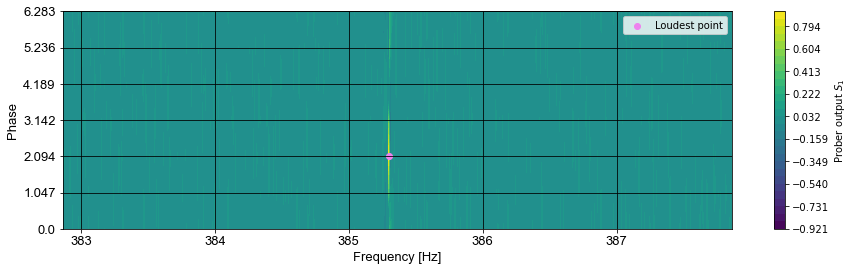

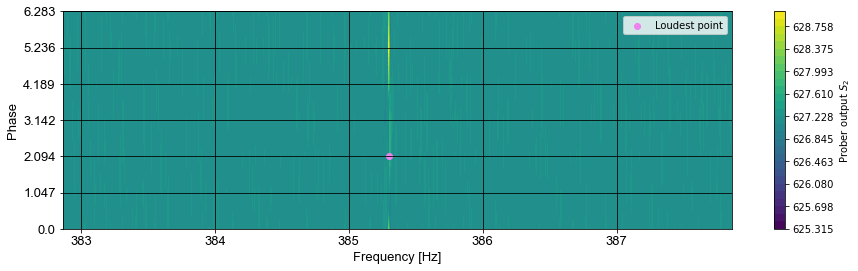

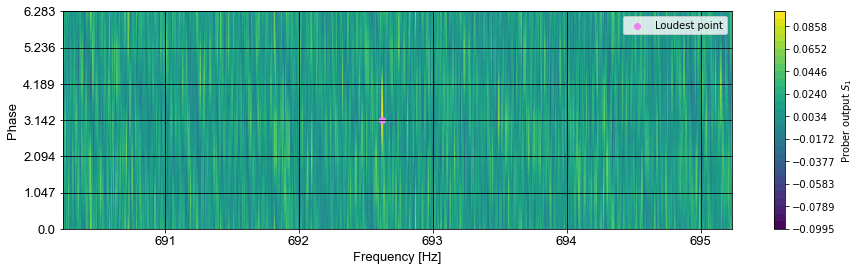

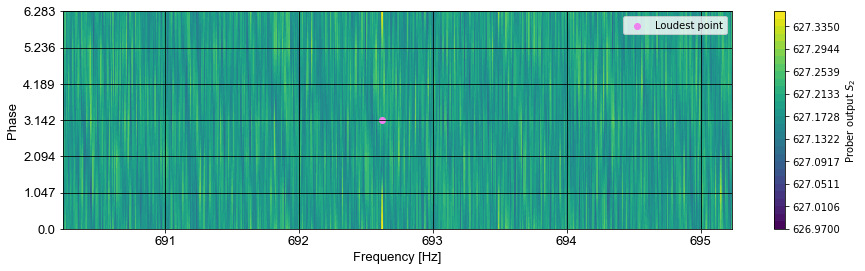

In [257]:
for i in range(len(temp_banks_data_02_stage1)):
    freq_list = np.loadtxt(temp_banks_data_02_stage1[i])[:,0]
    f_min_2 = min(freq_list)
    f_max_2 = max(freq_list)
    phase_freq_plot(data_02_results_m1_tb_stage1[i],freq=None, phase=None, N_df=1000, f_min=f_min_2, f_max=f_max_2, mod=1, 
                    N_ph=6, dx_axis_ticks = 0.02, fig_file_name = f"data_02_stage1_{str(i)}")
    phase_freq_plot(data_02_results_m2_tb_stage1[i],freq=None, phase=None, N_df=1000, f_min=f_min_2, f_max=f_max_2, mod=2, 
                    N_ph=6, dx_axis_ticks = 0.02, fig_file_name = f"data_02_stage1_{str(i)}")

Generating the template banks for dataset 3:

In [224]:
temp_banks_data_03_stage1 = generate_template_bank_list(m3_frequencies_data_03, 5, 1000, phase_steps = 6)

Analyse data 03 with method 1 and 2 of prober, using the template banks generated above:

In [229]:
%%time
data_03_results_m1_tb_stage1 = []
data_03_results_m2_tb_stage1 = []
for i in range(len(temp_banks_data_03_stage1)):
    data_03_results_m1_tb_stage1.append(prober(data_to_analyse[2], outputFile=f"result_03_f{str(m3_frequencies_data_03[i]).replace('.', '_')}_stage1_m1.txt", 
                                            templateFile=temp_banks_data_03_stage1[i], mod=1))
    data_03_results_m2_tb_stage1.append(prober(data_to_analyse[2], outputFile=f"result_03_f{str(m3_frequencies_data_03[i]).replace('.', '_')}_stage1_m2.txt", 
                                            templateFile=temp_banks_data_03_stage1[i], mod=2))

CPU times: total: 15.6 ms
Wall time: 40min 41s


In [54]:
get_best_result(data_03_results_m1_tb_005[0], method = 1)

array([57.97    ,  0.      ,  0.713291])

In [345]:
prober_with_tb_above_threshold(data_03_results_m1_tb_stage1[0], 0.075, method = 1)

[array([57.645    ,  1.0472   ,  0.0752135]),
 array([57.955   ,  2.0944  ,  0.103153]),
 array([57.96    ,  2.0944  ,  0.144191]),
 array([57.96    ,  3.14159 ,  0.108576]),
 array([57.965  ,  2.0944 ,  0.20016]),
 array([57.965  ,  3.14159,  0.2255 ]),
 array([57.97    ,  0.      ,  0.713291]),
 array([57.97    ,  1.0472  ,  0.264914]),
 array([57.97    ,  5.23599 ,  0.448371]),
 array([57.97    ,  6.28319 ,  0.713291]),
 array([57.99     ,  4.18879  ,  0.0901988])]

Plot the results in frequency-phase contour plots:

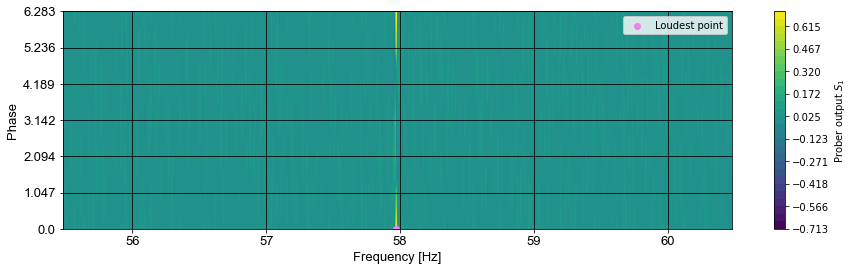

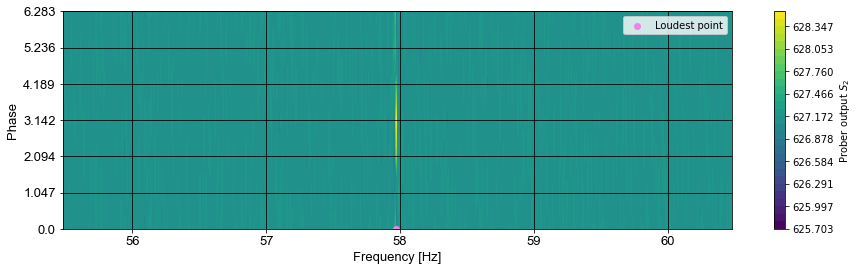

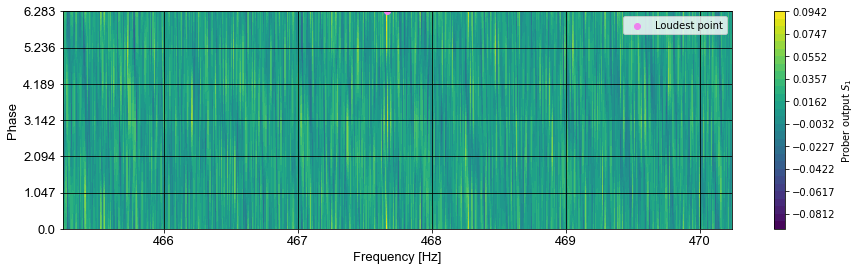

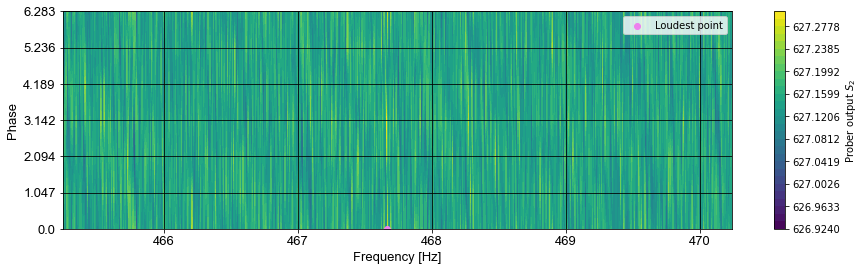

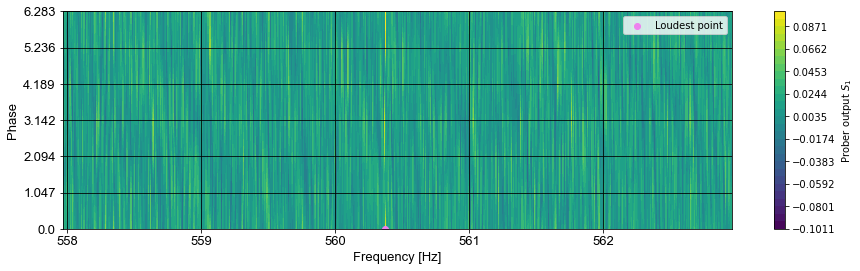

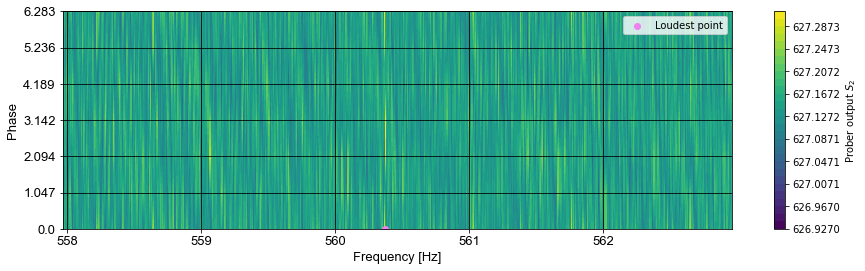

In [259]:
for i in range(len(temp_banks_data_03_stage1)):
    freq_list = np.loadtxt(temp_banks_data_03_stage1[i])[:,0]
    f_min_3 = min(freq_list)
    f_max_3 = max(freq_list)
    phase_freq_plot(data_03_results_m1_tb_stage1[i],freq=None, phase=None, N_df=1000, f_min=f_min_3, f_max=f_max_3, mod=1, 
                    N_ph=6, dx_axis_ticks = 0.02, fig_file_name = f"data_03_stage1_{str(i)}")
    phase_freq_plot(data_03_results_m2_tb_stage1[i],freq=None, phase=None, N_df=1000, f_min=f_min_3, f_max=f_max_3, mod=2, 
                    N_ph=6, dx_axis_ticks = 0.02, fig_file_name = f"data_03_stage1_{str(i)}")

Generating the template banks for dataset 4:

In [225]:
temp_banks_data_04_stage1 = generate_template_bank_list(m3_frequencies_data_04, 5, 1000, phase_steps = 6)

Analyse data 04 with method 1 and 2 of prober, using the template banks generated above:

In [230]:
%%time
data_04_results_m1_tb_stage1 = []
data_04_results_m2_tb_stage1 = []
for i in range(len(temp_banks_data_04_stage1)):
    data_04_results_m1_tb_stage1.append(prober(data_to_analyse[3], outputFile=f"result_04_f{str(m3_frequencies_data_04[i]).replace('.', '_')}_stage1_m1.txt", 
                                            templateFile=temp_banks_data_04_stage1[i], mod=1))
    data_04_results_m2_tb_stage1.append(prober(data_to_analyse[3], outputFile=f"result_04_f{str(m3_frequencies_data_04[i]).replace('.', '_')}_stage1_m2.txt", 
                                            templateFile=temp_banks_data_04_stage1[i], mod=2))

CPU times: total: 31.2 ms
Wall time: 51min 51s


In [84]:
get_best_result(data_04_results_m1_tb_005[6], method = 1)

array([8.87370e+02, 4.18879e+00, 7.66936e-01])

In [341]:
prober_with_tb_above_threshold(data_04_results_m1_tb_stage1[3], 0.075, method = 1)

[array([9.45776e+02, 3.14159e+00, 7.51051e-02])]

Plot the results in frequency-phase contour plots:

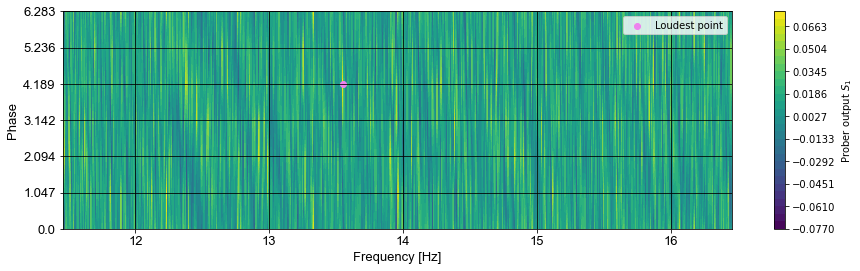

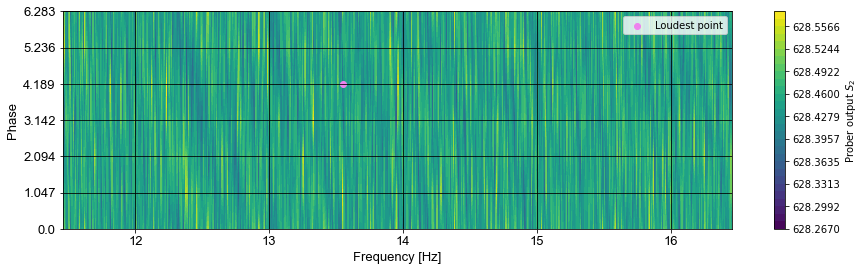

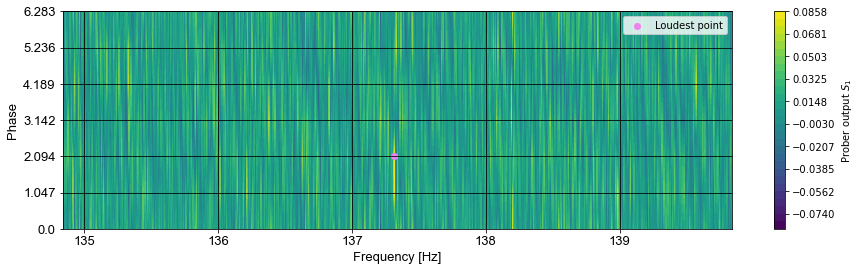

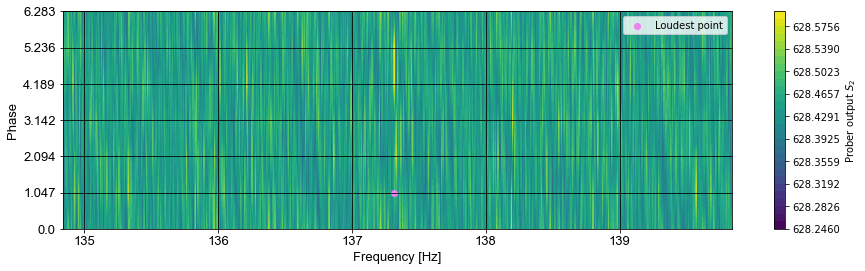

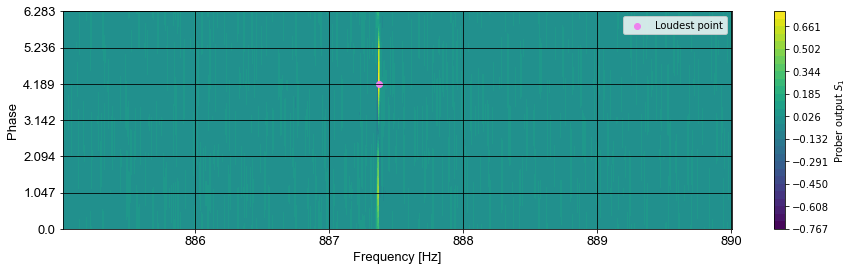

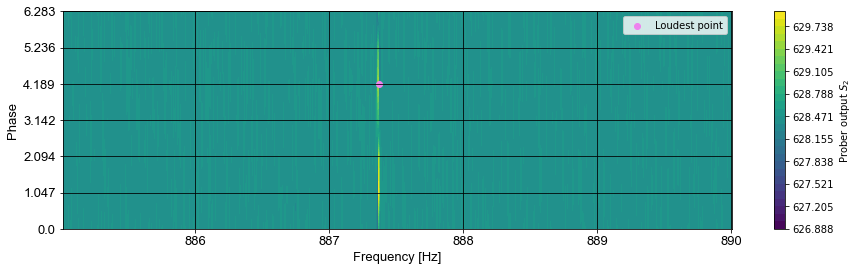

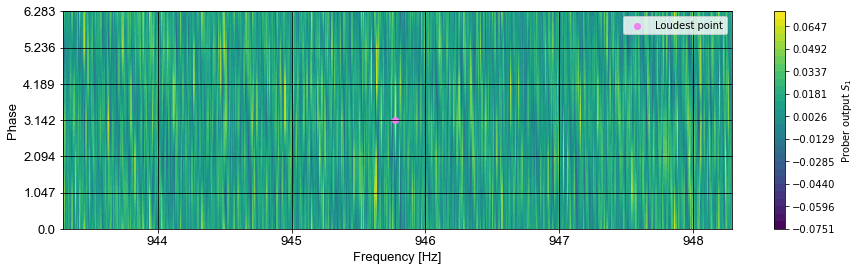

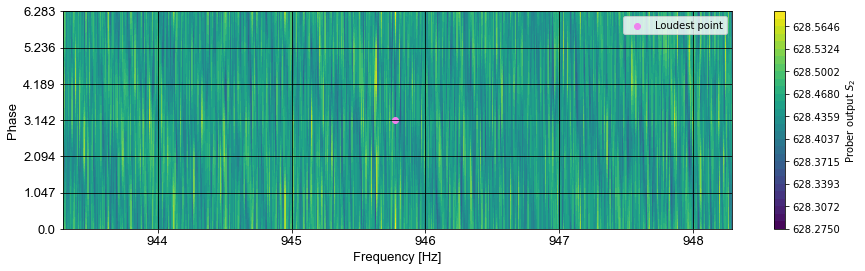

In [258]:
for i in range(len(temp_banks_data_04_stage1)):
    freq_list = np.loadtxt(temp_banks_data_04_stage1[i])[:,0]
    f_min_4 = min(freq_list)
    f_max_4 = max(freq_list)
    phase_freq_plot(data_04_results_m1_tb_stage1[i],freq=None, phase=None, N_df=1000, f_min=f_min_4, f_max=f_max_4, mod=1, 
                    N_ph=6, dx_axis_ticks = 0.02, fig_file_name = f"data_04_stage1_{str(i)}")
    phase_freq_plot(data_04_results_m2_tb_stage1[i],freq=None, phase=None, N_df=1000, f_min=f_min_4, f_max=f_max_4, mod=2, 
                    N_ph=6, dx_axis_ticks = 0.02, fig_file_name = f"data_04_stage1_{str(i)}")

Generating the tempalte banks for dataset 5:

In [226]:
temp_banks_data_05_stage1 = generate_template_bank_list(m3_frequencies_data_05, 5, 1000, phase_steps = 6)

Analyse data 05 with method 1 and 2 of prober, using the template banks generated above:

In [231]:
%%time
data_05_results_m1_tb_stage1 = []
data_05_results_m2_tb_stage1 = []
for i in range(len(temp_banks_data_05_stage1)):
    data_05_results_m1_tb_stage1.append(prober(data_to_analyse[4], outputFile=f"result_05_f{str(m3_frequencies_data_05[i]).replace('.', '_')}_stage1_m1.txt", 
                                            templateFile=temp_banks_data_05_stage1[i], mod=1))
    data_05_results_m2_tb_stage1.append(prober(data_to_analyse[4], outputFile=f"result_05_f{str(m3_frequencies_data_05[i]).replace('.', '_')}_stage1_m2.txt", 
                                            templateFile=temp_banks_data_05_stage1[i], mod=2))

CPU times: total: 46.9 ms
Wall time: 27min 32s


In [85]:
get_best_result(data_05_results_m1_tb_005[0], method = 1)

array([211.18    ,   2.0944  ,   0.729822])

In [343]:
prober_with_tb_above_threshold(data_05_results_m1_tb_stage1[1], 0.075, method = 1)

[array([5.19490e+02, 1.04720e+00, 1.00218e-01]),
 array([5.21530e+02, 0.00000e+00, 8.13292e-02]),
 array([5.21530e+02, 1.04720e+00, 8.35815e-02]),
 array([5.21530e+02, 6.28319e+00, 8.13290e-02]),
 array([5.21635e+02, 4.18879e+00, 7.68448e-02])]

Plot the results in frequency-phase contour plots:

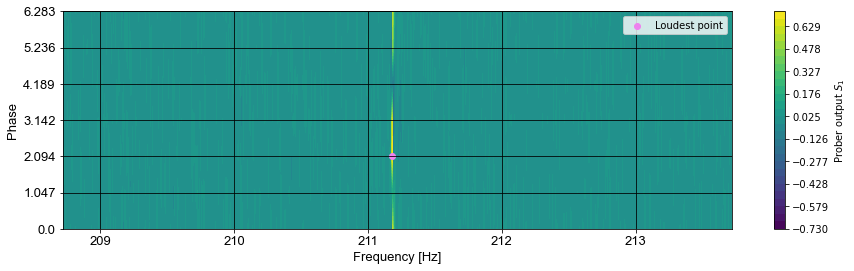

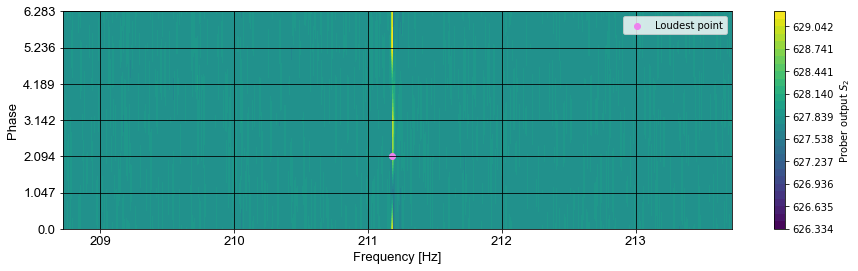

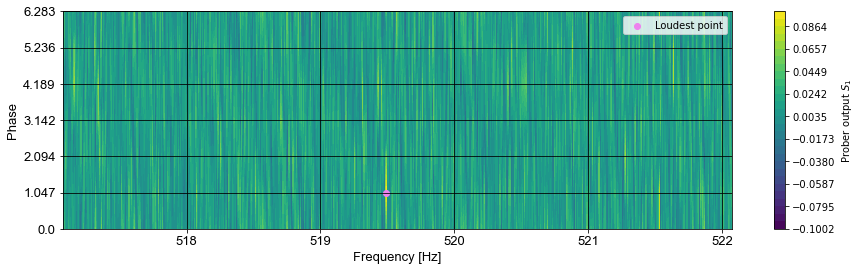

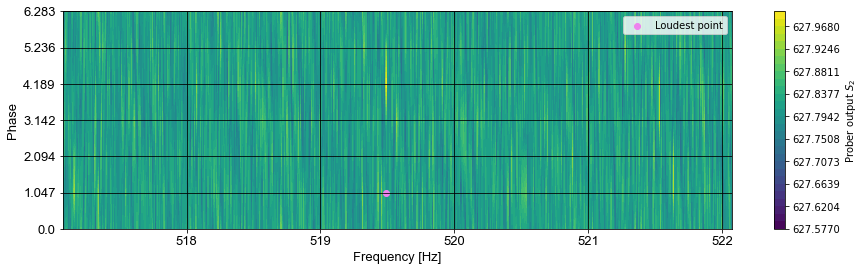

In [260]:
for i in range(len(temp_banks_data_05_stage1)):
    freq_list = np.loadtxt(temp_banks_data_05_stage1[i])[:,0]
    f_min_5 = min(freq_list)
    f_max_5 = max(freq_list)
    phase_freq_plot(data_05_results_m1_tb_stage1[i],freq=None, phase=None, N_df=1000, f_min=f_min_5, f_max=f_max_5, mod=1, 
                    N_ph=6, dx_axis_ticks = 0.02, fig_file_name = f"data_05_stage1{str(i)}")
    phase_freq_plot(data_05_results_m2_tb_stage1[i],freq=None, phase=None, N_df=1000, f_min=f_min_5, f_max=f_max_5, mod=2, 
                    N_ph=6, dx_axis_ticks = 0.02, fig_file_name = f"data_05_stage1_{str(i)}")

## Clustering and follow-up search

In [346]:
frequencies_data_01_stage2 = [18.408, 19.996, 20.006, 160.074, 160.439]
frequencies_data_02_stage2 = [112.108, 113.288, 163.574, 164.234, 164.679, 385.306, 385.354, 692.622]
frequencies_data_03_stage2 = [57.645, 57.955, 57.985, 467.664, 467.669]
frequencies_data_04_stage2 = [13.548, 137.315, 887.315, 887.365, 945.776]
frequencies_data_05_stage2 = [209.725, 211.185, 519.49, 521.53, 521.635]

In [347]:
temp_banks_data_01_stage2 = generate_template_bank_list(frequencies_data_01_stage2, 0.03, 30, phase_steps = 157)
temp_banks_data_02_stage2 = generate_template_bank_list(frequencies_data_02_stage2, 0.03, 30, phase_steps = 157)
temp_banks_data_03_stage2 = generate_template_bank_list(frequencies_data_03_stage2, 0.03, 30, phase_steps = 157)
temp_banks_data_04_stage2 = generate_template_bank_list(frequencies_data_04_stage2, 0.03, 30, phase_steps = 157)
temp_banks_data_05_stage2 = generate_template_bank_list(frequencies_data_05_stage2, 0.03, 30, phase_steps = 157)

In [348]:
%%time
data_01_results_m1_stage2 = []
data_01_results_m2_stage2 = []
for i in range(len(temp_banks_data_01_stage2)):
    data_01_results_m1_stage2.append(prober(data_to_analyse[0], outputFile=f"result_01_f{str(frequencies_data_01_stage2[i]).replace('.', '_')}_stage2_m1.txt", 
                                            templateFile=temp_banks_data_01_stage2[i], mod=1))
    data_01_results_m2_stage2.append(prober(data_to_analyse[0], outputFile=f"result_01_f{str(frequencies_data_01_stage2[i]).replace('.', '_')}_stage2_m2.txt", 
                                            templateFile=temp_banks_data_01_stage2[i], mod=2))

CPU times: total: 46.9 ms
Wall time: 49min 32s


In [566]:
get_best_result(data_01_results_m1_stage2[3], method = 1)

array([1.60073e+02, 5.36272e+00, 1.04441e-01])

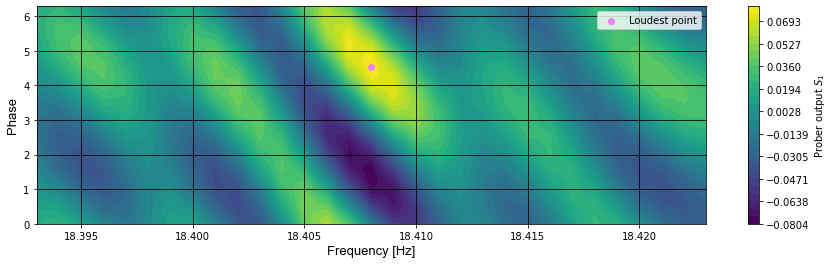

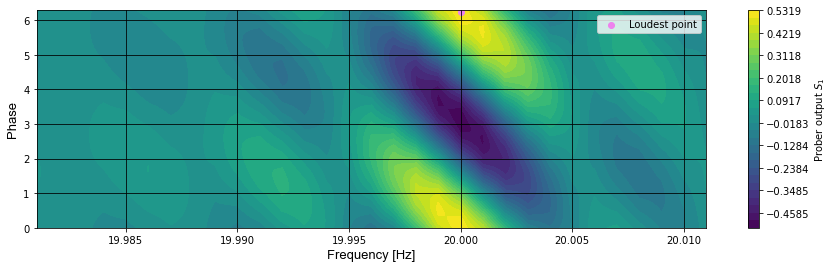

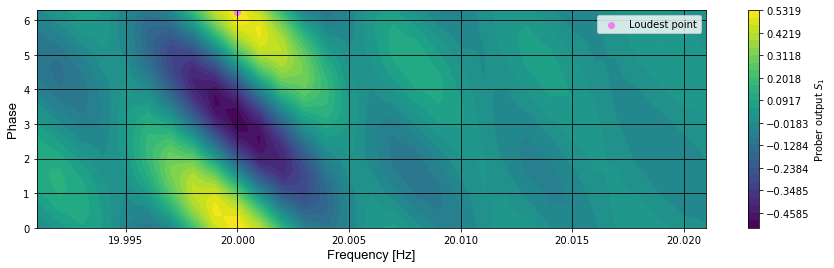

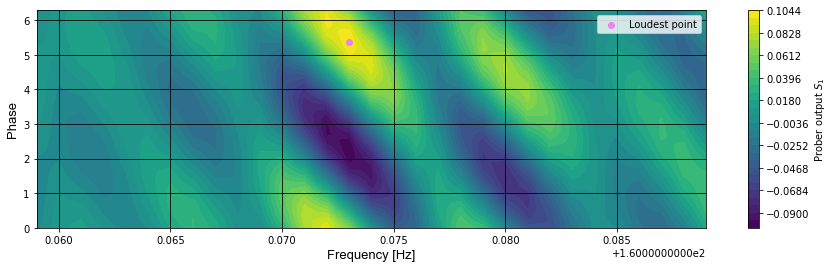

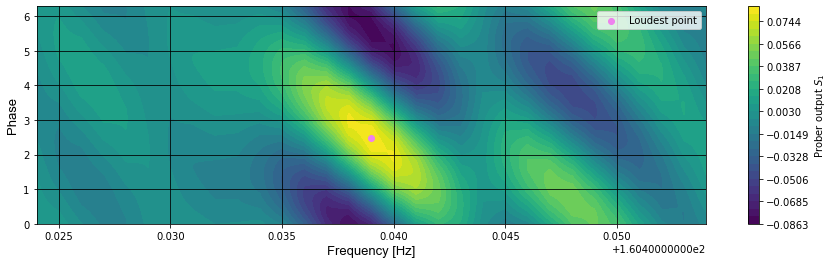

In [560]:
for i in range(len(temp_banks_data_01_stage2)):
    f_min_stage2 = frequencies_data_01_stage2[i] - 0.015
    f_max_stage2 = frequencies_data_01_stage2[i] + 0.015
    phase_freq_plot(data_01_results_m1_stage2[i],freq=None, phase=None, N_df = 30 , N_ph = 157, f_min = f_min_stage2, f_max = f_max_stage2,  mod=1, fig_file_name = f"data_01_stage2_{str(i)}")

[]

In [349]:
%%time
data_02_results_m1_stage2 = []
data_02_results_m2_stage2 = []
for i in range(len(temp_banks_data_02_stage2)):
    data_02_results_m1_stage2.append(prober(data_to_analyse[1], outputFile=f"result_02_f{str(frequencies_data_02_stage2[i]).replace('.', '_')}_stage2_m1.txt", 
                                            templateFile=temp_banks_data_02_stage2[i], mod=1))
    data_02_results_m2_stage2.append(prober(data_to_analyse[1], outputFile=f"result_02_f{str(frequencies_data_02_stage2[i]).replace('.', '_')}_stage2_m2.txt", 
                                            templateFile=temp_banks_data_02_stage2[i], mod=2))

CPU times: total: 46.9 ms
Wall time: 1h 22min 20s


In [572]:
get_best_result(data_02_results_m1_stage2[7], method = 1)

array([6.92623e+02, 2.72138e+00, 1.01663e-01])

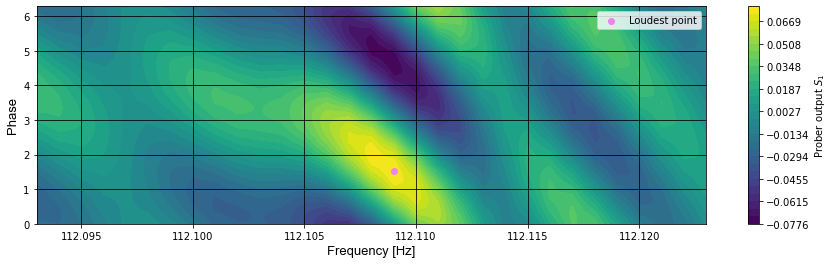

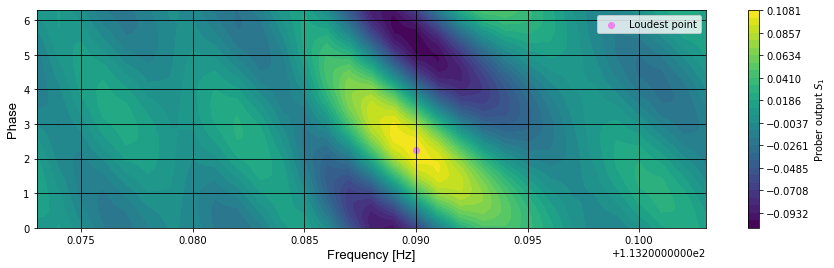

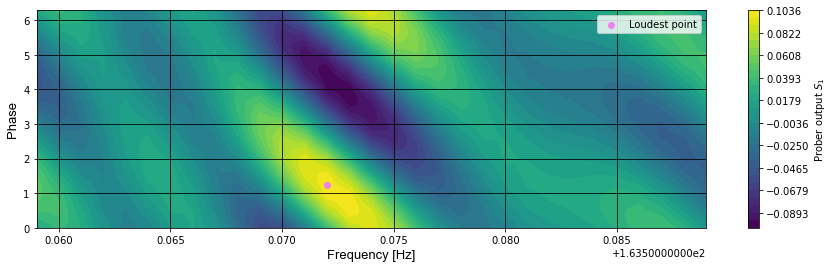

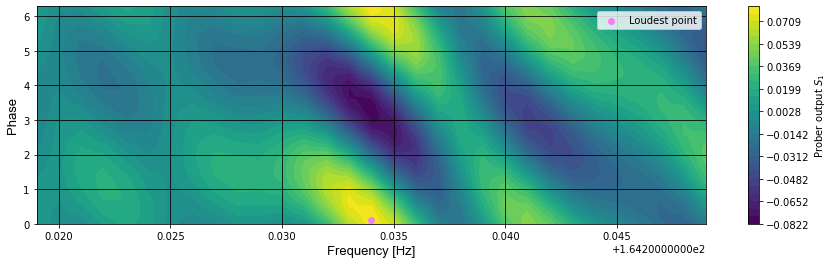

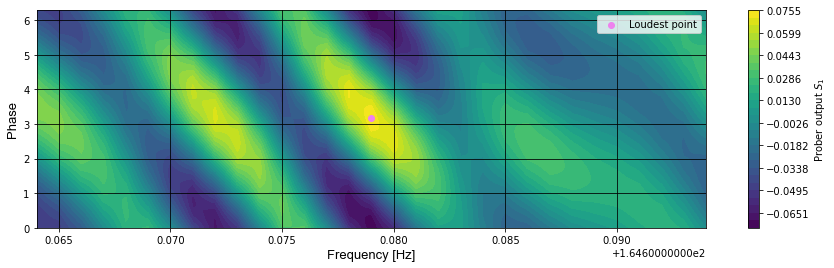

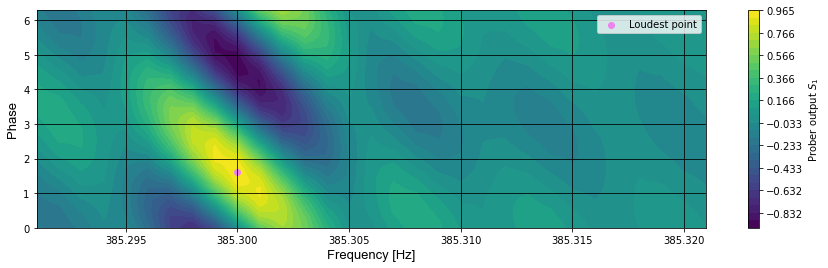

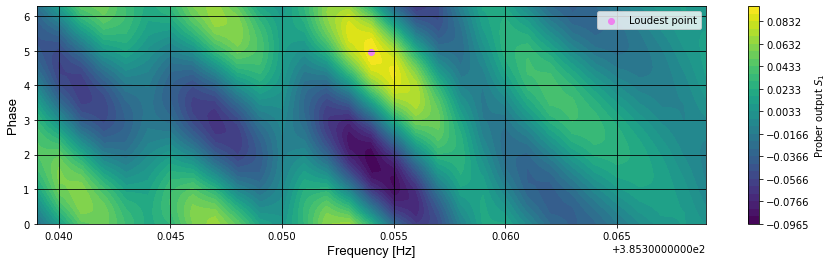

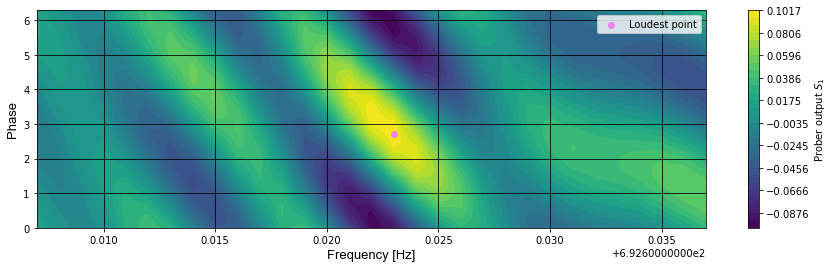

In [561]:
for i in range(len(temp_banks_data_02_stage2)):
    f_min_stage2 = frequencies_data_02_stage2[i] - 0.015
    f_max_stage2 = frequencies_data_02_stage2[i] + 0.015
    phase_freq_plot(data_02_results_m1_stage2[i],freq=None, phase=None, N_df = 30 , N_ph = 157, f_min = f_min_stage2, f_max = f_max_stage2,  mod=1, fig_file_name = f"data_02_stage2_{str(i)}")

In [350]:
%%time
data_03_results_m1_stage2 = []
data_03_results_m2_stage2 = []
for i in range(len(temp_banks_data_03_stage2)):
    data_03_results_m1_stage2.append(prober(data_to_analyse[2], outputFile=f"result_03_f{str(frequencies_data_03_stage2[i]).replace('.', '_')}_stage2_m1.txt", 
                                            templateFile=temp_banks_data_03_stage2[i], mod=1))
    data_03_results_m2_stage2.append(prober(data_to_analyse[2], outputFile=f"result_03_f{str(frequencies_data_03_stage2[i]).replace('.', '_')}_stage2_m2.txt", 
                                            templateFile=temp_banks_data_03_stage2[i], mod=2))

CPU times: total: 109 ms
Wall time: 52min 23s


In [577]:
get_best_result(data_03_results_m1_stage2[3], method = 1)

array([4.67666e+02, 4.96252e+00, 1.08991e-01])

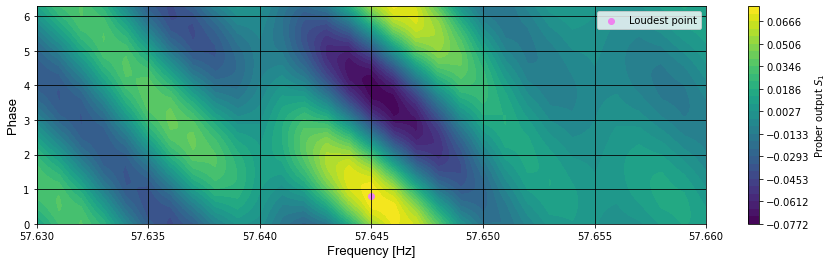

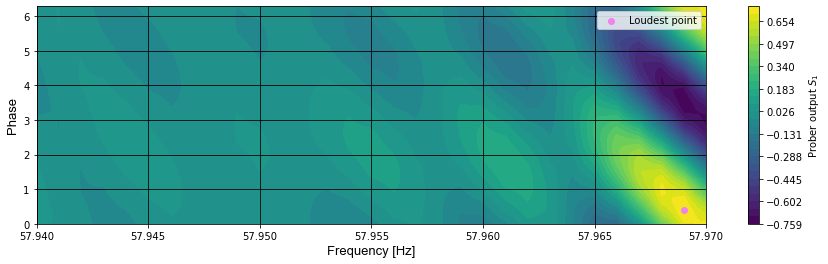

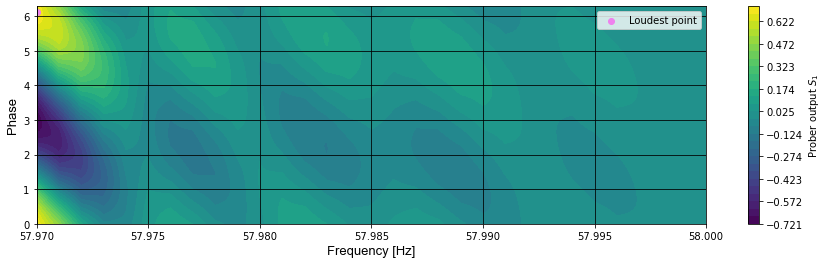

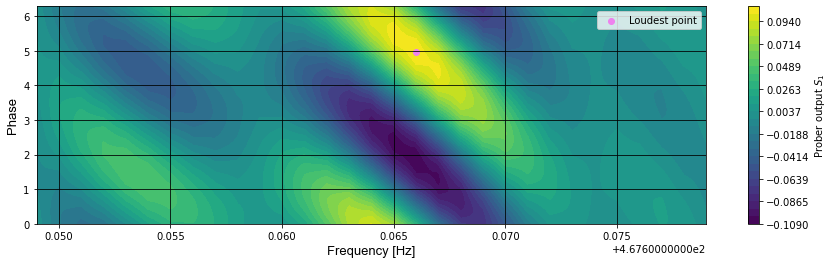

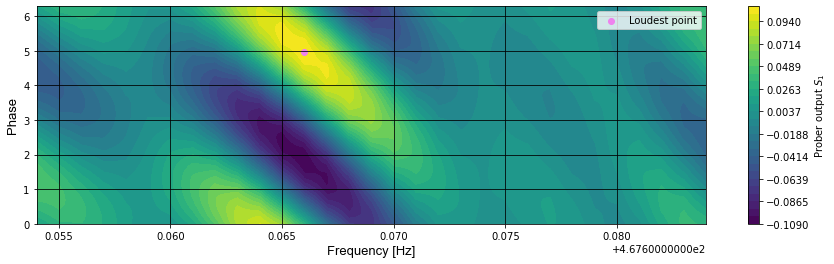

In [562]:
for i in range(len(temp_banks_data_03_stage2)):
    f_min_stage2 = frequencies_data_03_stage2[i] - 0.015
    f_max_stage2 = frequencies_data_03_stage2[i] + 0.015
    phase_freq_plot(data_03_results_m1_stage2[i],freq=None, phase=None, N_df = 30 , N_ph = 157, f_min = f_min_stage2, f_max = f_max_stage2,  mod=1, fig_file_name = f"data_03_stage2_{str(i)}")

In [502]:
%%time
data_04_results_m1_stage2 = []
data_04_results_m2_stage2 = []
for i in range(len(temp_banks_data_04_stage2)):
    data_04_results_m1_stage2.append(prober(data_to_analyse[3], outputFile=f"result_04_f{str(frequencies_data_04_stage2[i]).replace('.', '_')}_stage2_m1.txt", 
                                            templateFile=temp_banks_data_04_stage2[i], mod=1))
    data_04_results_m2_stage2.append(prober(data_to_analyse[3], outputFile=f"result_04_f{str(frequencies_data_04_stage2[i]).replace('.', '_')}_stage2_m2.txt", 
                                            templateFile=temp_banks_data_04_stage2[i], mod=2))

CPU times: total: 31.2 ms
Wall time: 48min 17s


In [583]:
get_best_result(data_04_results_m1_stage2[3], method = 1)

array([887.368   ,   5.64286 ,   0.969394])

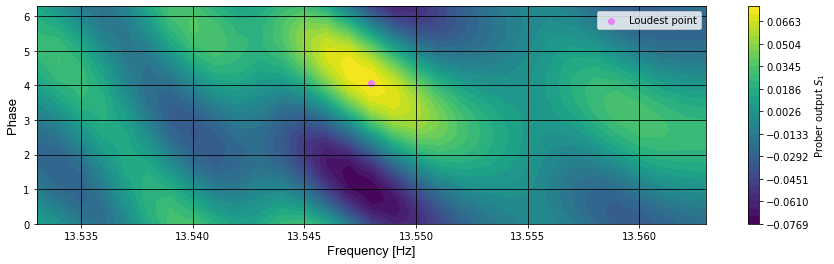

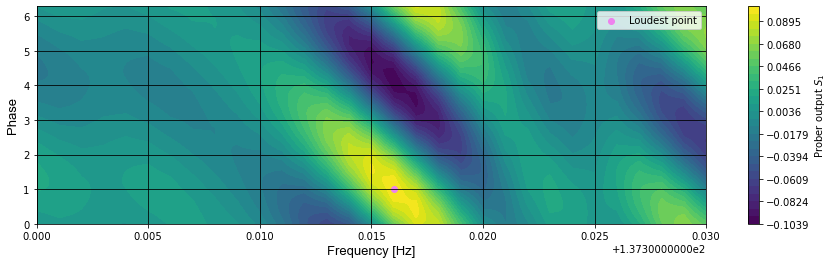

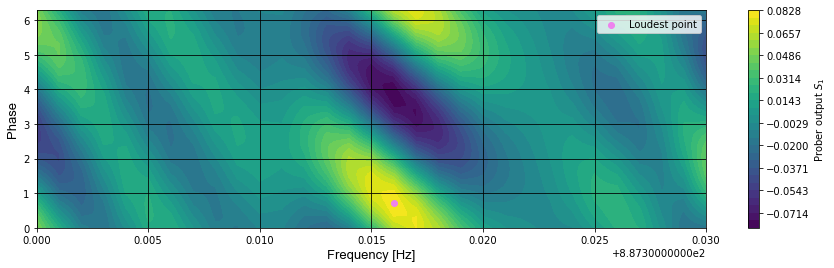

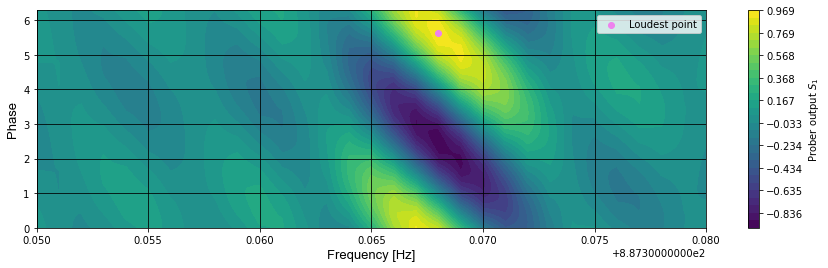

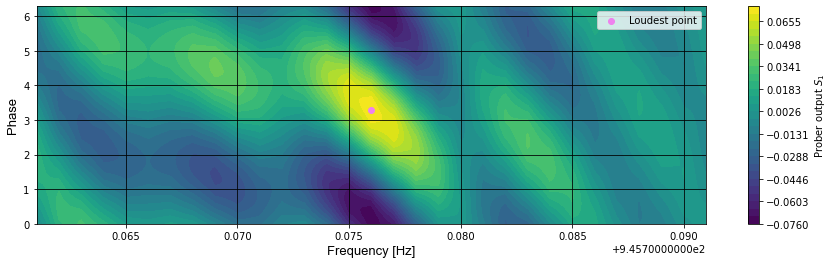

In [563]:
for i in range(len(temp_banks_data_04_stage2)):
    f_min_stage2 = frequencies_data_04_stage2[i] - 0.015
    f_max_stage2 = frequencies_data_04_stage2[i] + 0.015
    phase_freq_plot(data_04_results_m1_stage2[i],freq=None, phase=None, N_df = 30 , N_ph = 157, f_min = f_min_stage2, f_max = f_max_stage2,  mod=1, fig_file_name = f"data_04_stage2_{str(i)}")

In [352]:
%%time
data_05_results_m1_stage2 = []
data_05_results_m2_stage2 = []
for i in range(len(temp_banks_data_05_stage2)):
    data_05_results_m1_stage2.append(prober(data_to_analyse[4], outputFile=f"result_05_f{str(frequencies_data_05_stage2[i]).replace('.', '_')}_stage2_m1.txt", 
                                            templateFile=temp_banks_data_05_stage2[i], mod=1))
    data_05_results_m2_stage2.append(prober(data_to_analyse[4], outputFile=f"result_05_f{str(frequencies_data_05_stage2[i]).replace('.', '_')}_stage2_m2.txt", 
                                            templateFile=temp_banks_data_05_stage2[i], mod=2))

CPU times: total: 62.5 ms
Wall time: 54min 48s


In [585]:
get_best_result(data_05_results_m1_stage2[2], method = 1)

array([5.19489e+02, 1.68085e+00, 1.02627e-01])

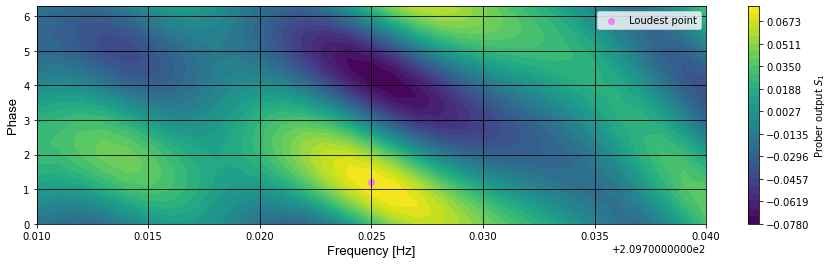

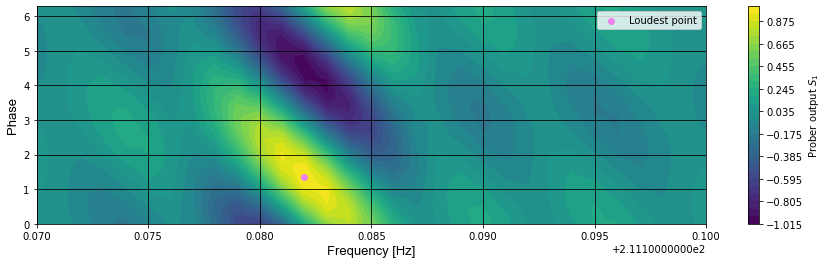

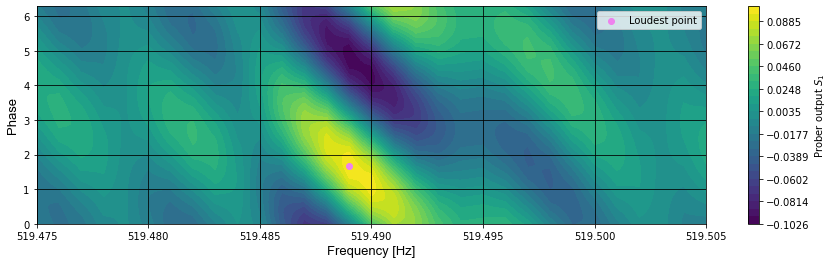

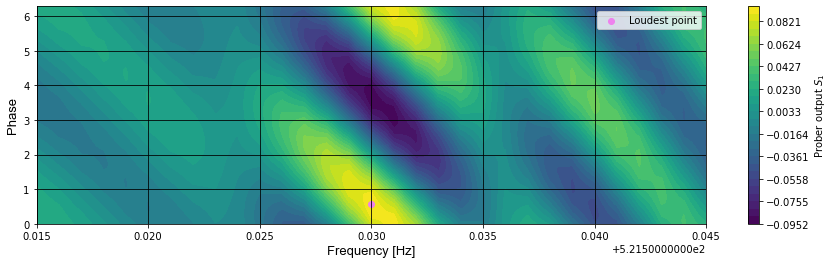

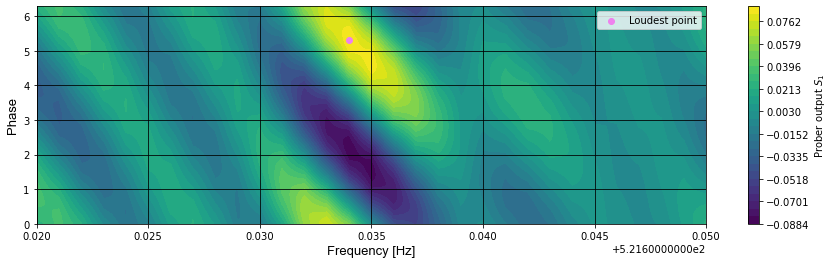

In [564]:
for i in range(len(temp_banks_data_05_stage2)):
    f_min_stage2 = frequencies_data_05_stage2[i] - 0.015
    f_max_stage2 = frequencies_data_05_stage2[i] + 0.015
    phase_freq_plot(data_05_results_m1_stage2[i],freq=None, phase=None, N_df = 30 , N_ph = 157, f_min = f_min_stage2, f_max = f_max_stage2,  mod=1, fig_file_name = f"data_05_stage2_{str(i)}")

## Plotting the ROC - Curve (without template banks)

To obtain a ROC-curve, multiple sources with and without signal are generated and analysed using method 1 and 2 of prober. 

In [24]:
# generates as many sources with the given parameters as given by number_of_sources
# the values of sigma, dT and N are the same as in the actual data sets to be analysed
# output: list of file paths of the generated sources
def generate_sources_list(file_name_body, number_of_sources, freq = 0, phase = 0, amplitude = 0):
     
    file_paths = []
    
    for i in range(number_of_sources):
        
        generate_source(
            outputFile=f"{file_name_body}_{i}.txt", 
            sigma=sigma_data, 
            delta_T=dt_data, 
            N=N_data,
            f=freq, 
            phi=phase, 
            A=amplitude, 
            r=0
        )
        file_paths.append(f"{output_dir}/{file_name_body}_{i}.txt")
    
    return file_paths

In [79]:
# returns the maximum value of S1 or minimum value of S2 and the corresponding phase and frequency of the results of prober used with a template bank
# input: path to file with results of prober, method
# output: [frequency, phase, max. S1]
def best_result_of_prober(result_file_path, method):
    
    input_data = np.loadtxt(result_file_path)
    #freq_list = input_data[:,0]
    #phase_list = input_data[:,1]
    s_list = input_data[:,2]
    
    if method == 1:
        best_index = np.argmax(s_list)
    elif method == 2:
        best_index = np.argmin(s_list)
    else: 
        print("This is not a valid method.")
        return []
    
    
    return input_data[best_index]
    

In [449]:
def analyze_file_list_m12(file_list, freq, phase, method):
    
    s_list = []
    
    for i in range(len(file_list)):
        result_list = prober_m12(file_list[i], f=freq, phi=phase, mod=method)
        s_list.append(result_list[2])
    
    return s_list

In [468]:
# plots a histogram of the s-values in s_noise_list and s_signal_list
# saves plot in a png image with the given file name
def plot_histogram(s_noise_list, s_signal_list, method = 1, plot_title = None, fig_name = None):
    
    plt.hist(s_noise_list, bins = 200, label = "Noise")
    plt.hist(s_signal_list, bins = 200, label = "Noise and signal")
    plt.xlabel(f"S$_{str(method)}$", fontname="Arial", fontsize=13)
    plt.ylabel("Number", fontname="Arial", fontsize=13)
    plt.xticks(fontname="Arial", fontsize=13)
    plt.yticks(fontname="Arial", fontsize=13)
    if plot_title:
        plt.title(f"Histogram for method {str(method)}, {plot_title}")
    else:
        plt.title(f"Histogram for method {str(method)}")
    plt.legend(loc='upper left')
    plt.savefig(f"histogram_mod{str(method)}_{fig_name}.png", dpi=800)
    plt.show()
    
    return 

In [454]:
# To generate the ROC curve, the threshold to distinguish between noise/signal is varied.
# For the different thresholds, the true positive rate is plotted vs. the false positive rate.
def plot_roc_curve(noise_list, signal_list, n_a, method, plot_title = None, fig_name = None):
    
    # determine the range of s-values in the given files
    s_min = min([min(noise_list), min(signal_list)])
    s_max = max([max(noise_list), max(signal_list)])
    
    # get a list of threshold values
    a_list = np.linspace(s_min,s_max,n_a)
    
    # determine the true positive and false negative rate for all thresholds 
    # save the results in two lists: false positive list, true positive list
    
    N_noise = len(noise_list)
    N_signal = len(signal_list)
    
    false_positive_list = []
    true_positive_list = []
    
    for i in range(len(a_list)):
        fp_count = 0
        tp_count = 0
        for j in range(N_noise):
            if method == 1 and noise_list[j] > a_list[i]:
                fp_count += 1
            elif method == 2 and noise_list[j] < a_list[i]:
                fp_count +=1
                
        false_positive_list.append(fp_count/N_noise)
            
        for k in range(N_signal):
            if method == 1 and signal_list[k] > a_list[i]:
                tp_count += 1
            elif method == 2 and signal_list[k] < a_list[i]:
                tp_count +=1
                
        true_positive_list.append(tp_count/N_signal)
            
    result_list = []
    for n in range(len(a_list)):
        result_list.append([a_list[n], true_positive_list[n], false_positive_list[n]])
        
    
    plt.plot(false_positive_list, true_positive_list)
    plt.xlabel("False positive rate", fontname="Arial", fontsize=13)
    plt.ylabel("True positive rate", fontname="Arial", fontsize=13)
    plt.xticks(fontname="Arial", fontsize=13)
    plt.yticks(fontname="Arial", fontsize=13)
    
    if plot_title:
        plt.title("ROC curve: " + plot_title)
    #else: 
        #plt.title("ROC curve")
        
    plt.savefig(f"ROC_curve_mod{str(method)}_{fig_name}.png", dpi=800)
    plt.show()
        
    return result_list

In [447]:
roc_noise_list = []
roc_signal_list_a05 = []
roc_signal_list_a1 = []
roc_signal_list_a15 = []
roc_signal_list_a2 = []
for i in range(200):
    roc_noise_list.append(os.path.join(data_dir, f"roc_noise_{i+1}.txt"))
    roc_signal_list_a05.append(os.path.join(data_dir, f"roc_signal_05_{i+1}.txt"))
    roc_signal_list_a1.append(os.path.join(data_dir, f"roc_signal_1_{i+1}.txt"))
    roc_signal_list_a15.append(os.path.join(data_dir, f"roc_signal_15_{i+1}.txt"))
    roc_signal_list_a2.append(os.path.join(data_dir, f"roc_signal_2_{i+1}.txt"))
    

In [450]:
# analyse the noise and signal files using method 1
s1_list_noise = analyze_file_list_m12(roc_noise_list, freq = 437.127, phase = 2.41, method = 1)
s1_list_signal_05 = analyze_file_list_m12(roc_signal_list_a05, freq = 437.127, phase = 2.41, method = 1)
s1_list_signal_1 = analyze_file_list_m12(roc_signal_list_a1, freq = 437.127, phase = 2.41, method = 1)
s1_list_signal_15 = analyze_file_list_m12(roc_signal_list_a15, freq = 437.127, phase = 2.41, method = 1)
s1_list_signal_2 = analyze_file_list_m12(roc_signal_list_a2, freq = 437.127, phase = 2.41, method = 1)
# analyse the noise and signal files using method 2
s2_list_noise = analyze_file_list_m12(roc_noise_list, freq = 437.127, phase = 2.41, method = 2)
s2_list_signal_05 = analyze_file_list_m12(roc_signal_list_a05, freq = 437.127, phase = 2.41, method = 2)
s2_list_signal_1 = analyze_file_list_m12(roc_signal_list_a1, freq = 437.127, phase = 2.41, method = 2)
s2_list_signal_15 = analyze_file_list_m12(roc_signal_list_a15, freq = 437.127, phase = 2.41, method = 2)
s2_list_signal_2 = analyze_file_list_m12(roc_signal_list_a2, freq = 437.127, phase = 2.41, method = 2)

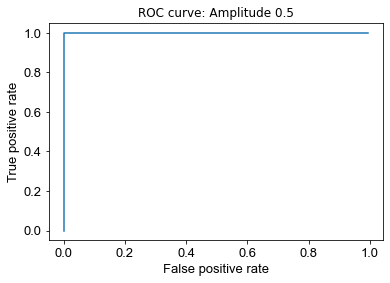

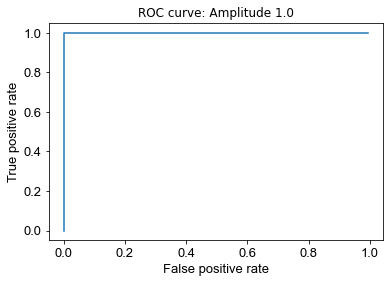

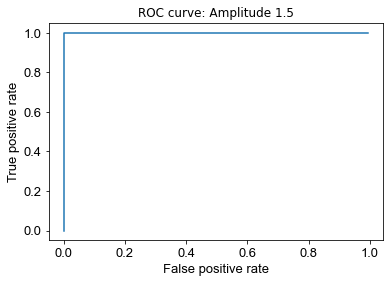

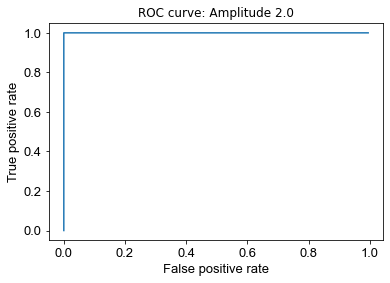

[[-0.0570418, 1.0, 0.995],
 [-0.05648495067533767, 1.0, 0.995],
 [-0.05592810135067534, 1.0, 0.995],
 [-0.055371252026013, 1.0, 0.995],
 [-0.05481440270135067, 1.0, 0.99],
 [-0.05425755337668834, 1.0, 0.99],
 [-0.05370070405202601, 1.0, 0.99],
 [-0.05314385472736368, 1.0, 0.99],
 [-0.05258700540270135, 1.0, 0.99],
 [-0.052030156078039014, 1.0, 0.99],
 [-0.051473306753376684, 1.0, 0.985],
 [-0.050916457428714354, 1.0, 0.985],
 [-0.050359608104052024, 1.0, 0.985],
 [-0.049802758779389694, 1.0, 0.985],
 [-0.04924590945472736, 1.0, 0.985],
 [-0.04868906013006503, 1.0, 0.985],
 [-0.0481322108054027, 1.0, 0.985],
 [-0.04757536148074037, 1.0, 0.985],
 [-0.04701851215607804, 1.0, 0.985],
 [-0.0464616628314157, 1.0, 0.985],
 [-0.04590481350675337, 1.0, 0.985],
 [-0.04534796418209104, 1.0, 0.985],
 [-0.04479111485742871, 1.0, 0.98],
 [-0.04423426553276638, 1.0, 0.98],
 [-0.043677416208104045, 1.0, 0.98],
 [-0.043120566883441715, 1.0, 0.98],
 [-0.042563717558779385, 1.0, 0.98],
 [-0.0420068682341

In [536]:
plot_roc_curve(s1_list_noise, s1_list_signal_05, 500, method = 1, plot_title = "Amplitude 0.5", fig_name = "_no_tb_a05")
plot_roc_curve(s1_list_noise, s1_list_signal_1, 500, method = 1, plot_title = "Amplitude 1.0", fig_name = "_no_tb_a1")
plot_roc_curve(s1_list_noise, s1_list_signal_15, 500, method = 1, plot_title = "Amplitude 1.5", fig_name = "_no_tb_a15")
plot_roc_curve(s1_list_noise, s1_list_signal_2, 2000, method = 1, plot_title = "Amplitude 2.0", fig_name = "_no_tb_a2")

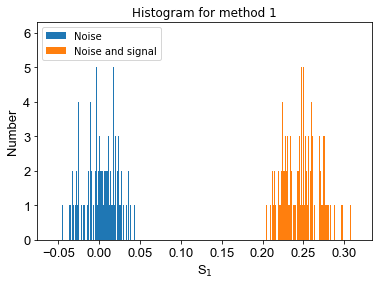

In [472]:
plot_histogram(s1_list_noise, s1_list_signal_05, method = 1, plot_title = None, fig_name = "no_tb_a05")

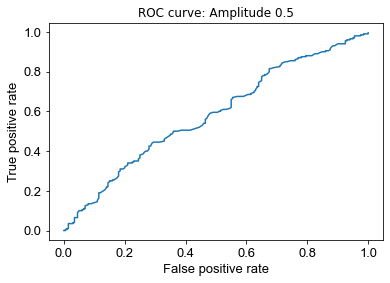

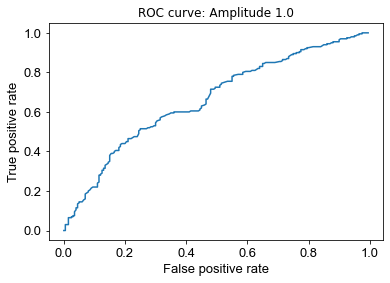

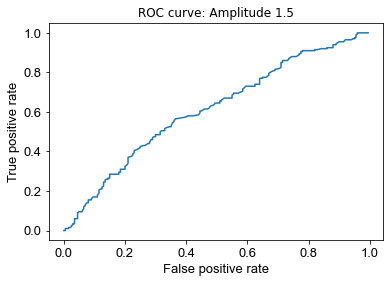

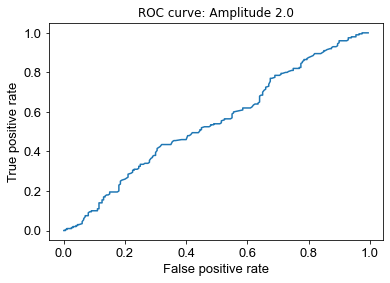

[[622.031, 0.0, 0.0],
 [622.0420841683366, 0.0, 0.005],
 [622.0531683366733, 0.0, 0.005],
 [622.06425250501, 0.0, 0.005],
 [622.0753366733467, 0.0, 0.005],
 [622.0864208416833, 0.0, 0.005],
 [622.09750501002, 0.0, 0.005],
 [622.1085891783566, 0.0, 0.005],
 [622.1196733466934, 0.0, 0.005],
 [622.13075751503, 0.0, 0.005],
 [622.1418416833667, 0.0, 0.005],
 [622.1529258517033, 0.0, 0.005],
 [622.16401002004, 0.0, 0.005],
 [622.1750941883768, 0.0, 0.005],
 [622.1861783567134, 0.0, 0.005],
 [622.1972625250501, 0.0, 0.005],
 [622.2083466933867, 0.0, 0.005],
 [622.2194308617234, 0.0, 0.005],
 [622.23051503006, 0.0, 0.005],
 [622.2415991983968, 0.0, 0.005],
 [622.2526833667334, 0.0, 0.005],
 [622.2637675350701, 0.0, 0.005],
 [622.2748517034067, 0.0, 0.005],
 [622.2859358717434, 0.0, 0.005],
 [622.2970200400802, 0.0, 0.005],
 [622.3081042084168, 0.0, 0.005],
 [622.3191883767535, 0.0, 0.005],
 [622.3302725450901, 0.0, 0.005],
 [622.3413567134268, 0.0, 0.005],
 [622.3524408817635, 0.0, 0.005],
 [

In [457]:
plot_roc_curve(s2_list_noise, s2_list_signal_05, 500, method = 2, plot_title = "Amplitude 0.5", fig_name = "_no_tb_a05")
plot_roc_curve(s2_list_noise, s2_list_signal_1, 500, method = 2, plot_title = "Amplitude 1.0", fig_name = "_no_tb_a1")
plot_roc_curve(s2_list_noise, s2_list_signal_15, 500, method = 2, plot_title = "Amplitude 1.5", fig_name = "_no_tb_a15")
plot_roc_curve(s2_list_noise, s2_list_signal_2, 500, method = 2, plot_title = "Amplitude 2.0", fig_name = "_no_tb_a2")